# Plot mean, variance and correlation for yearly timescale and all data sets

In [4]:
%reload_ext autoreload
%autoreload 2

from plotting import *
from evaluate import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from interpolate import get_interpolated_data_and_gt
import matplotlib
import matplotlib.gridspec as gridspec

In [5]:
base_folder = "Datasets"
output_folder = "Output/Crossprediction"

In [6]:
# for nice plotting:
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 300

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

### Load data

In [7]:
conditions = dict()
conditions["iHadCM3"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "TARGET_VARIABLES": {'isotopes': ['d18O']},
                                "CLIMATE_MODEL": "iHadCM3",                                
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["GISS"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "CLIMATE_MODEL": "GISS",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["isoGSM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "CLIMATE_MODEL": "isoGSM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["iCESM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "CLIMATE_MODEL": "iCESM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }


In [8]:
gt_l = []
descriptions_l = []
masks_l = []

for label, c in conditions.items():
    descriptions, _, gt, masks = load_data_for_comparison(output_folder, c)
    gt_l.append(gt)
    descriptions_l.append(descriptions)
    masks_l.append(masks)

10 matching runs found
10 matching runs found
10 matching runs found
10 matching runs found


### Mean states

C:\Users\49159\AppData\Local\Temp/ipykernel_14164/4282718890.py:13: RuntimeWarning: Mean of empty slice
  plot_map(ax, np.nanmean(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style,


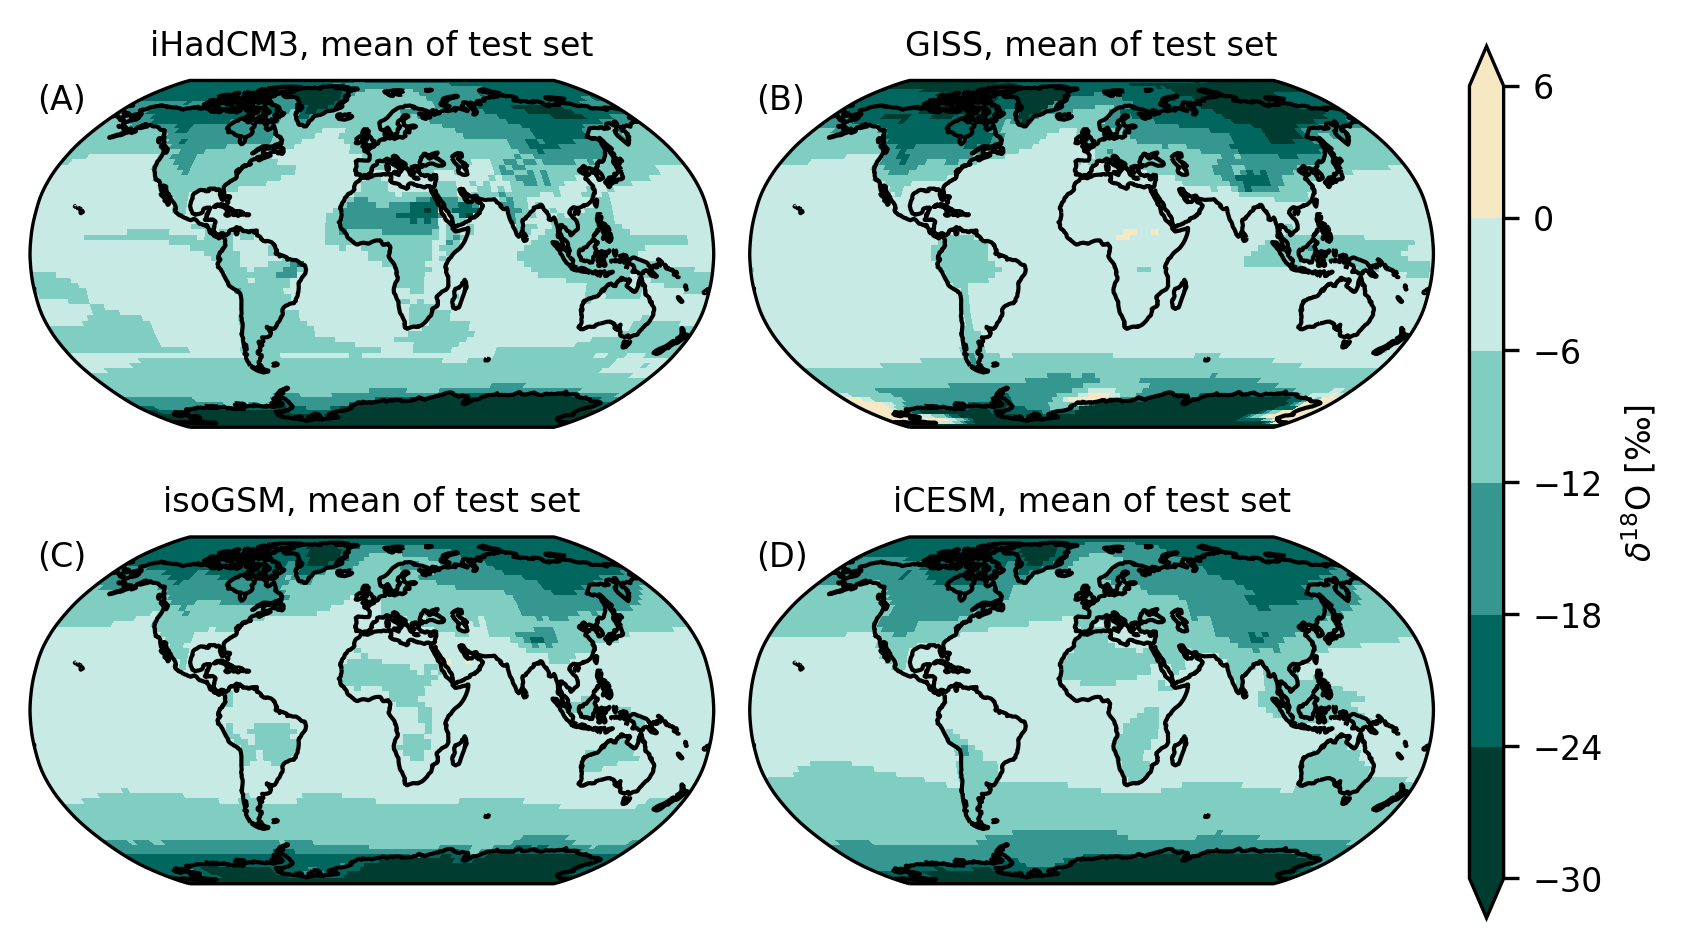

In [6]:
n_rows=2
n_cols=2

figure_width = textwidth
figure_height = 0.8* textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

for i, key in enumerate(list(conditions.keys())):
    ax = fig.add_subplot(gs[i//2,i%2], projection=mean_style["PROJECTION"])
    plot_map(ax, np.nanmean(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style, 
             title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", mean of test set", show_colorbar=False)
    add_label_to_axes(ax, "({})".format(alphabet_letters[i]), mean_style)

ax_cb=plt.subplot(gs[:,n_cols])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=mean_style["CMAP"], norm=mean_style["NORM"]), cax=ax_cb, extend=mean_style["CBAR_EXTEND"])
cbar.set_label(mean_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/means.jpg")
plt.savefig("Images/means.png")
plt.savefig("Images/means.pdf")
plt.savefig("Images/means.svg")
plt.show()

### Standard deviations

C:\Users\49159\Anaconda3\envs\GrouPyTorch\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


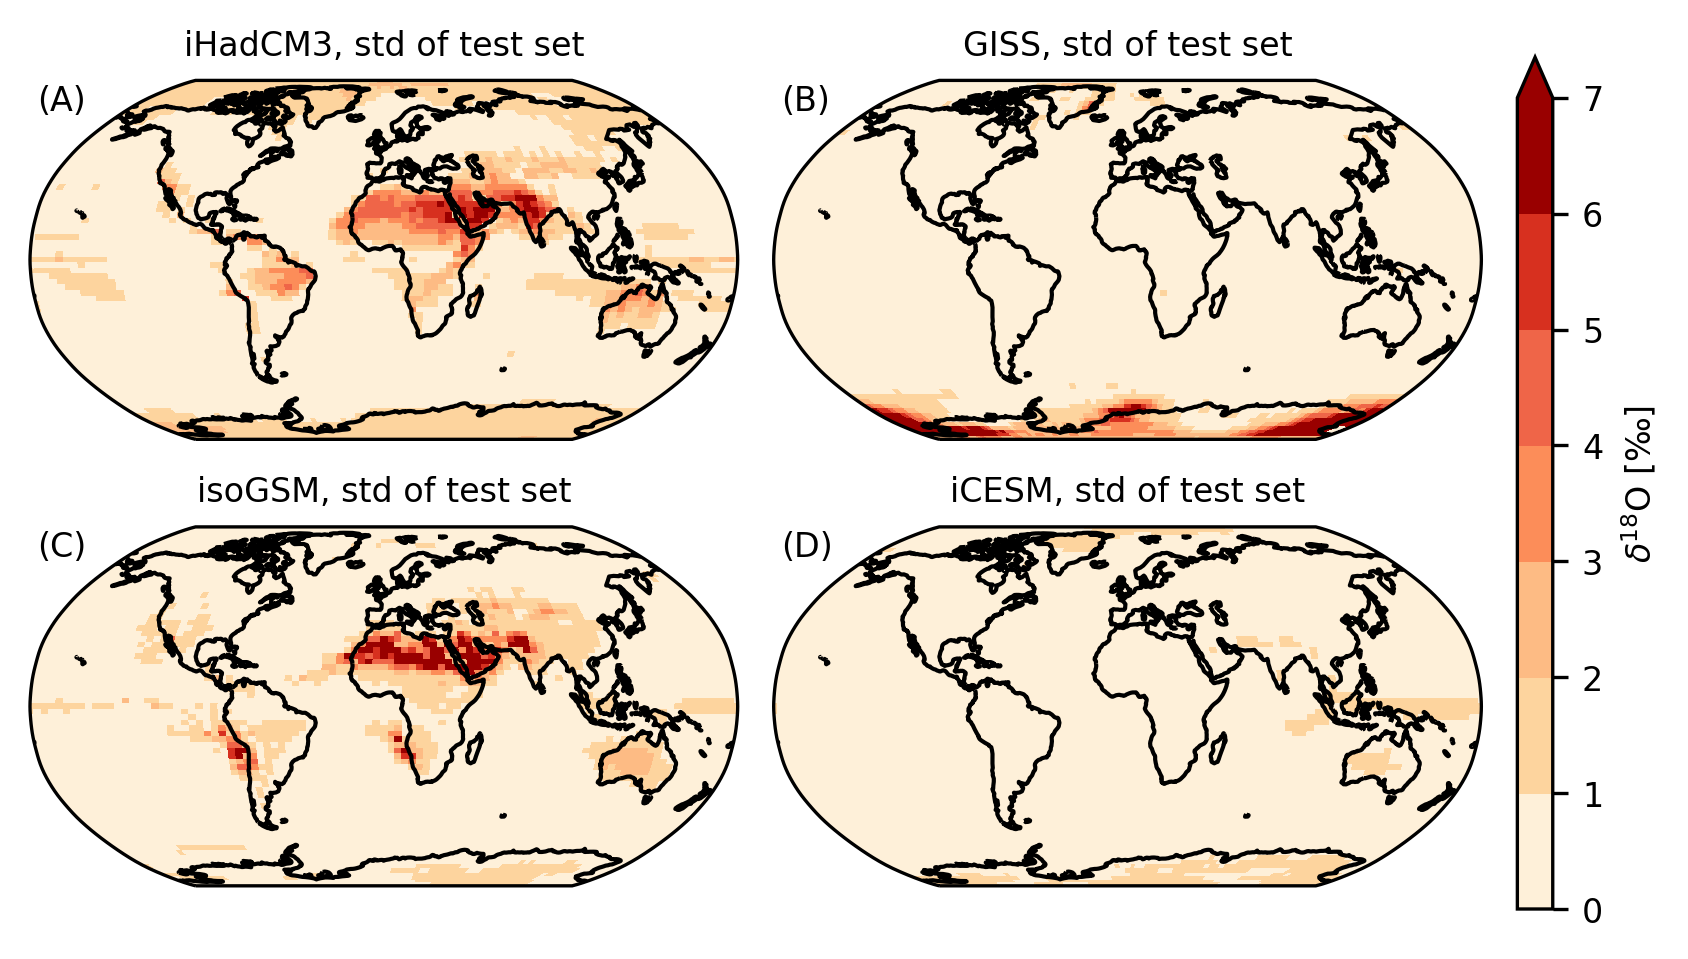

In [7]:
n_rows=2
n_cols=2

figure_width = textwidth
figure_height = 0.8* textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

for i, key in enumerate(list(conditions.keys())):    
    ax = fig.add_subplot(gs[i//2,i%2], projection=std_style["PROJECTION"])
    plot_map(ax, np.nanstd(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], std_style, 
             title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", std of test set", show_colorbar=False)
    add_label_to_axes(ax, "({})".format(alphabet_letters[i]), std_style)

ax_cb=plt.subplot(gs[:,n_cols])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=std_style["CMAP"], norm=std_style["NORM"]), cax=ax_cb, extend=std_style["CBAR_EXTEND"])
cbar.set_label(std_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/stds.jpg")
plt.savefig("Images/stds.png")
plt.savefig("Images/stds.pdf")
plt.savefig("Images/stds.svg")
plt.show()

### Correlation maps

In [8]:
dsets = []
for d in descriptions_l:
    dsets.append(find_and_load_dataset(output_folder, d[0]["DATASET_DESCRIPTION"]))

In [9]:
data_dicts = []
for ds in dsets:
    t = ds["train"]["predictors"][:,:1,...]  # second index is for specifying the variables
    p = ds["train"]["predictors"][:,1:,...]  # second index is for specifying the variables
    o = ds["train"]["targets"][:]
    
    c_t = get_correlation(t,o)[0,...]
    c_p = get_correlation(p,o)[0,...]

    max_cor = np.amax([abs(c_p),abs(c_t)], axis=0)
    argmax_cor = np.argmax([abs(c_p),abs(c_t)],axis=0)
    
    tas_mask = np.where((argmax_cor == 1),True,False)
    pr_mask = np.where((argmax_cor == 0),True,False)

    tas_img = np.ma.masked_array(max_cor, np.invert(tas_mask))
    pr_img = np.ma.masked_array(max_cor, np.invert(pr_mask))

    data_dict = {"tsurf": tas_img,
                 "prec": pr_img}
    data_dicts.append(data_dict)

C:\Users\49159\Anaconda3\envs\GrouPyTorch\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


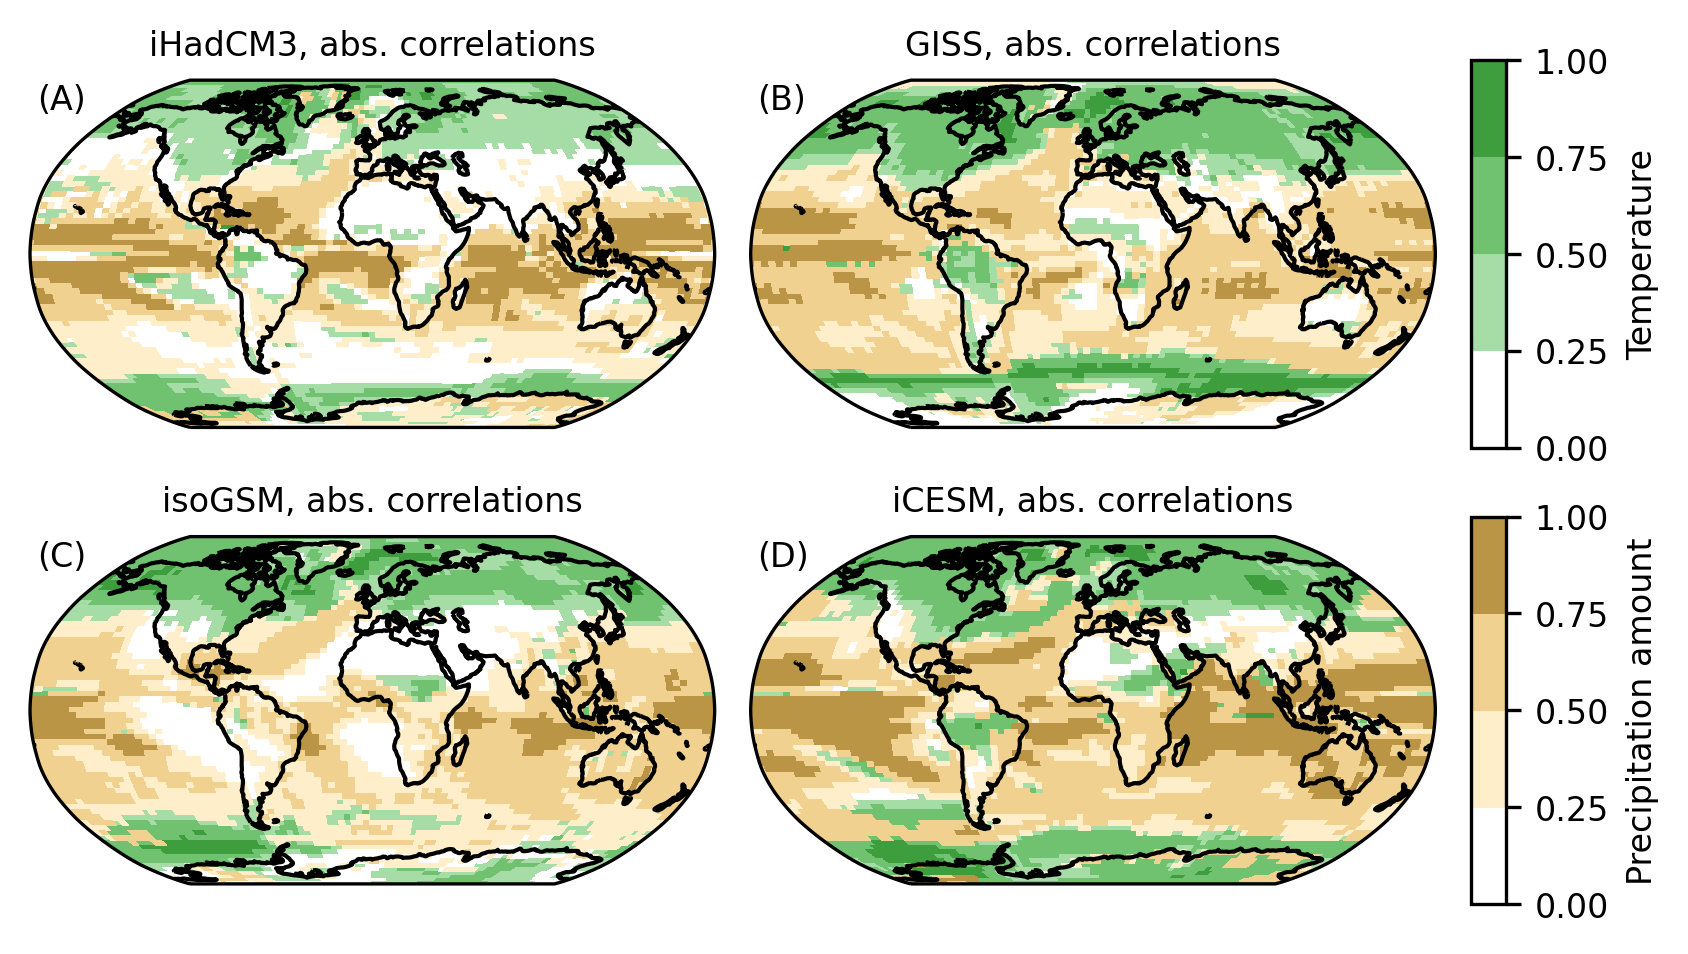

In [10]:
n_rows=2
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows)/(n_cols) / std_style["ASPECT_RATIO"]

fig = plt.figure(figsize=[figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])


for i, m_key in enumerate(list(conditions.keys())):        
    ax = fig.add_subplot(gs[i//2,i%2], projection= corr_style["PROJECTION"])

    plot_masked_data(ax, data_dicts[i], descriptions_l[i][0]["DATASET_DESCRIPTION"], corr_style, 
                     title=m_key +", abs. correlations")
    add_label_to_axes(ax, "({})".format(alphabet_letters[i]), std_style)

fig.canvas.draw()
fig.tight_layout()

key = "tsurf"
ax_cb1=plt.subplot(gs[0,n_cols])
cbar1 = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]), cax=ax_cb1, extend=corr_style["CBAR_EXTEND"])
cbar1.set_label(corr_style["CBAR_LABELS"][key])

key = "prec"
ax_cb2=plt.subplot(gs[1,n_cols])
cbar2 = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]), cax=ax_cb2, extend=corr_style["CBAR_EXTEND"])
cbar2.set_label(corr_style["CBAR_LABELS"][key])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/corrs.jpg")
plt.savefig("Images/corrs.png")
plt.savefig("Images/corrs.pdf")
plt.savefig("Images/corrs.svg")
plt.show()

### HadCM3 plots in one.

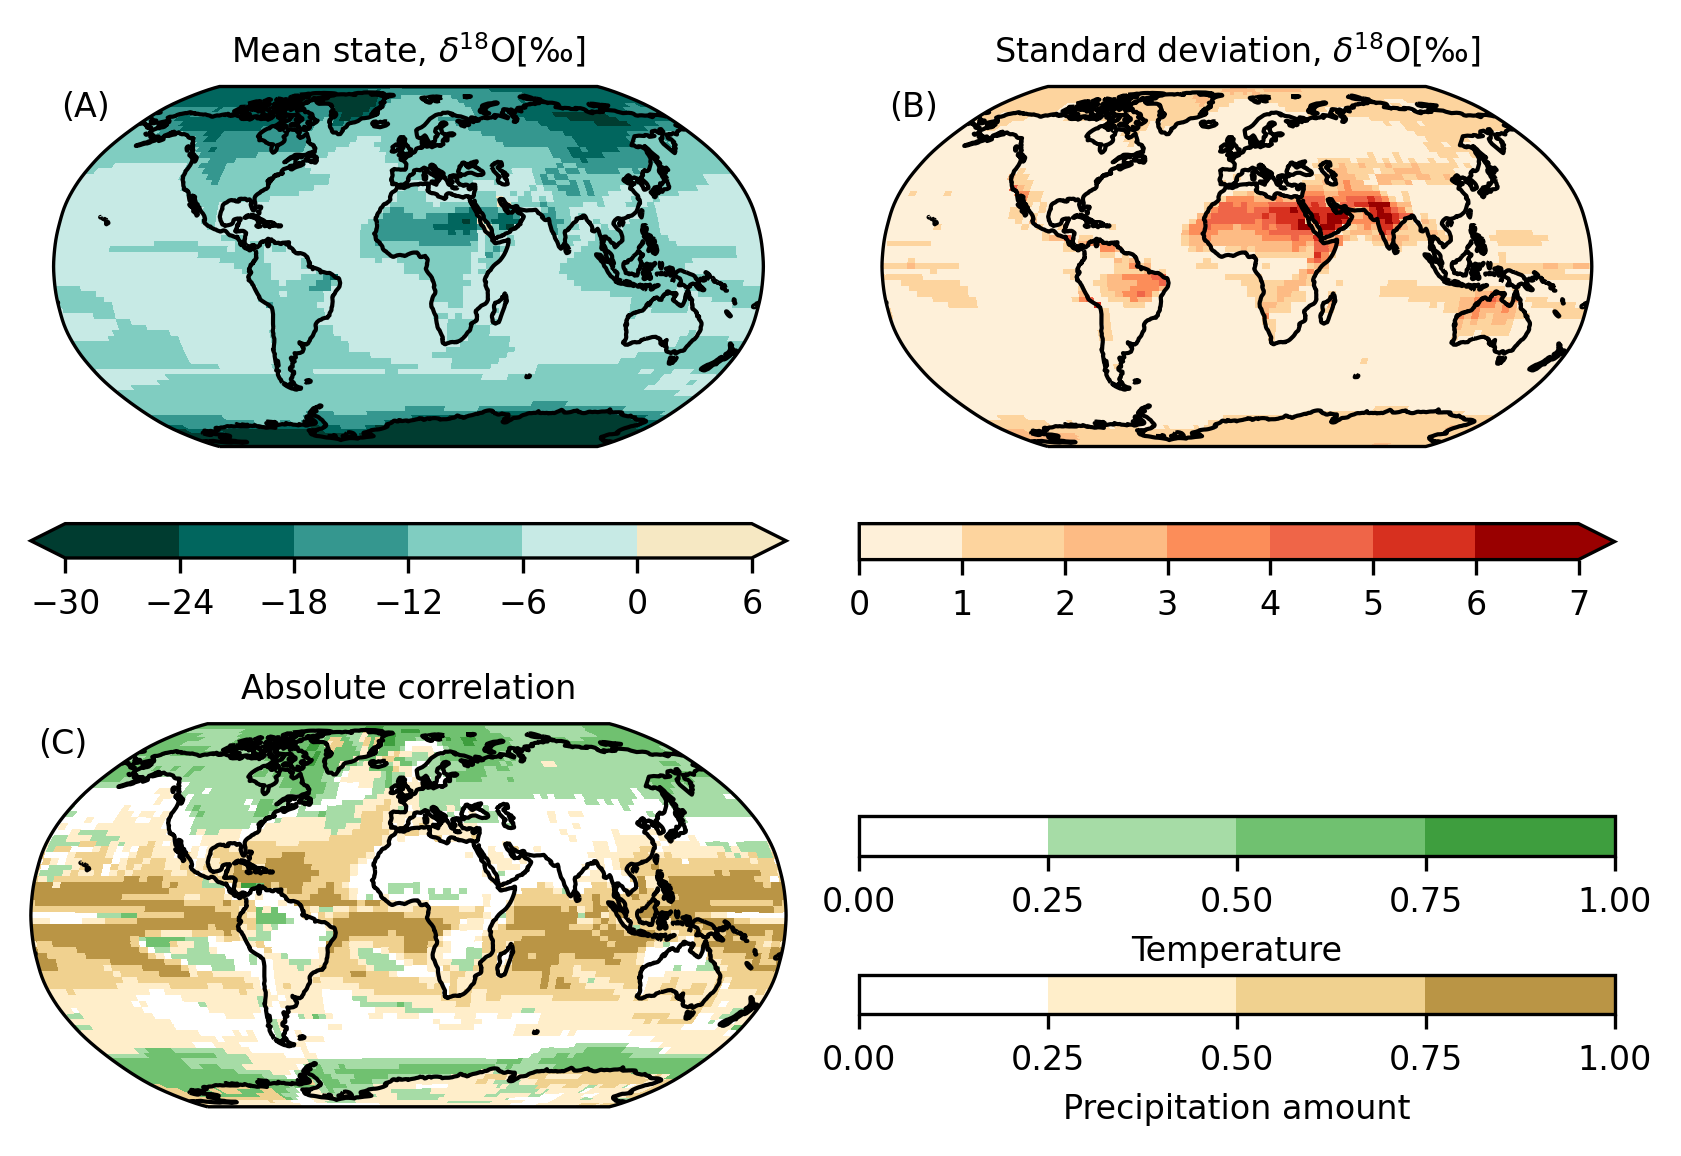

In [11]:
i = 0  # index of desired climate model

n_rows = 2
n_cols = 2

# h_colorbars = 0.05  # height of the colorbar panels

figure_width = textwidth
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize=[figure_width, figure_height])
gs = gridspec.GridSpec(nrows=n_rows, ncols=n_cols,
                       figure=fig, height_ratios=[1, 1])

# mean:
ax_1 = fig.add_subplot(gs[0, 0], projection=mean_style["PROJECTION"])
plot_map(ax_1, np.nanmean(gt_l[i][0], axis=(0, 1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style,
         title="Mean state, $\delta{}^{18}$O$ [‰]$",
         show_colorbar=True, show_colorbar_label=False)
add_label_to_axes(ax_1, "({})".format(alphabet_letters[0]), std_style)

# std:
ax_2 = fig.add_subplot(gs[0, 1], projection=std_style["PROJECTION"])
plot_map(ax_2, np.nanstd(gt_l[i][0], axis=(0, 1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], std_style,
         title="Standard deviation, $\delta{}^{18}$O$ [‰]$",
         show_colorbar=True, show_colorbar_label=False)
add_label_to_axes(ax_2, "({})".format(alphabet_letters[1]), std_style)

ax_3 = fig.add_subplot(gs[1, 0], projection=corr_style["PROJECTION"])
plot_masked_data(ax_3, data_dicts[i], descriptions_l[i][0]["DATASET_DESCRIPTION"], corr_style,
                 title="Absolute correlation")
add_label_to_axes(ax_3, "({})".format(alphabet_letters[2]), std_style)

# colorbars
gs00 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[1,1], hspace=3)

ax_c3 = fig.add_subplot(gs00[1])
key = "tsurf"
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]),
                    cax=ax_c3, extend=corr_style["CBAR_EXTEND"], spacing='proportional', orientation='horizontal',)
cbar.set_label(corr_style["CBAR_LABELS"][key])


ax_c4 = fig.add_subplot(gs00[2])
key = "prec"
cbar2 = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]),
                    cax=ax_c4, extend=corr_style["CBAR_EXTEND"], spacing='proportional', orientation='horizontal',)
cbar2.set_label(corr_style["CBAR_LABELS"][key])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/iHadCM3_stats.jpg")
plt.savefig("Images/iHadCM3_stats.png")
plt.savefig("Images/iHadCM3_stats.pdf")
plt.savefig("Images/iHadCM3_stats.svg")
plt.show()


# Develop map plot with markers at locations.

In [4]:
conditions_best = {
    "DATASET_DESCRIPTION": {
                            "PRECIP_WEIGHTING" : False
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "FMAPS": (64,64,128,128),
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  }
}
descriptions_best, predictions_best, gt_best, masks_best = load_data_for_comparison("Output/Reproduce_new/", conditions_best)
r2_best_mean = np.zeros(len(predictions_best))
r2_best = np.zeros((len(predictions_best), *predictions_best[0].shape[1:]))

for i in range(len(predictions_best)):
    r2_best[i] = get_r2(predictions_best[i], gt_best[i])
    r2_best_mean[i] = get_weighted_average(get_r2(predictions_best[i], gt_best[i]), descriptions_best[i]["DATASET_DESCRIPTION"])

10 matching runs found


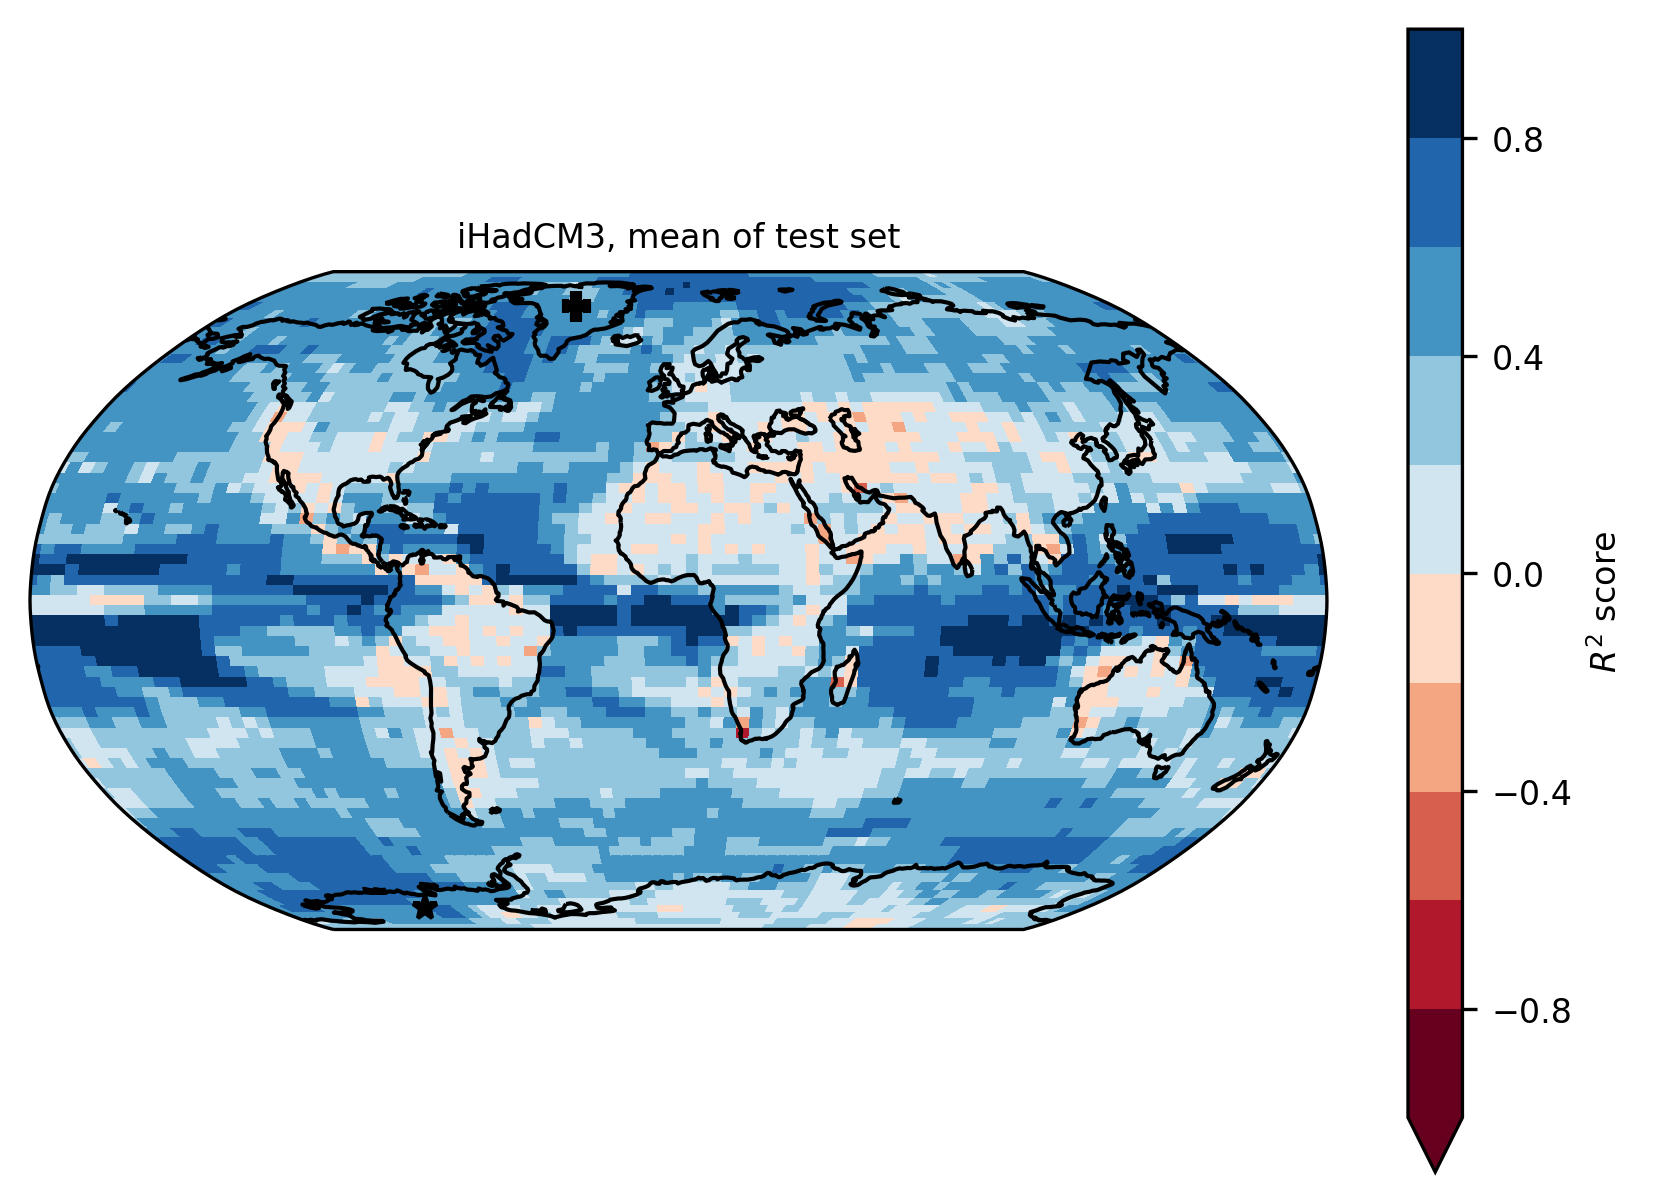

In [5]:
locs = np.array([[-79.5,-112.1],[75.1,-42.3]]) # ,[-75.1, 123.4],[-75.0, 0.1]])
locs[:,1] = locs[:,1]%360
locs_labels = ["WAIS Divide", "NGRIP"] # ,"EPICA - Concordia", "EPICA - Kohnen"]

n_rows=1
n_cols=1
figure_width = textwidth
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[figure_width, figure_height], subplot_kw={'projection': r2_style["PROJECTION"]})
plot_map_markers(ax, locs, np.nanmean(r2_best,axis=(0,1)), descriptions_best[0]["DATASET_DESCRIPTION"], style=r2_style, 
            title=descriptions_best[0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", mean of test set", locs_labels=locs_labels)

fig.canvas.draw()
fig.tight_layout()

plt.show()

### Test if we can plot this side by side with time series-


In [6]:
locs = np.array([[-79.5,-112.1],[75.1,-42.3]]) # ,[-75.1, 123.4],[-75.0, 0.1]])
locs[:,1] = locs[:,1]%360
locs_labels = ["WAIS Divide", "NGRIP"] # ,"EPICA - Concordia", "EPICA - Kohnen"]

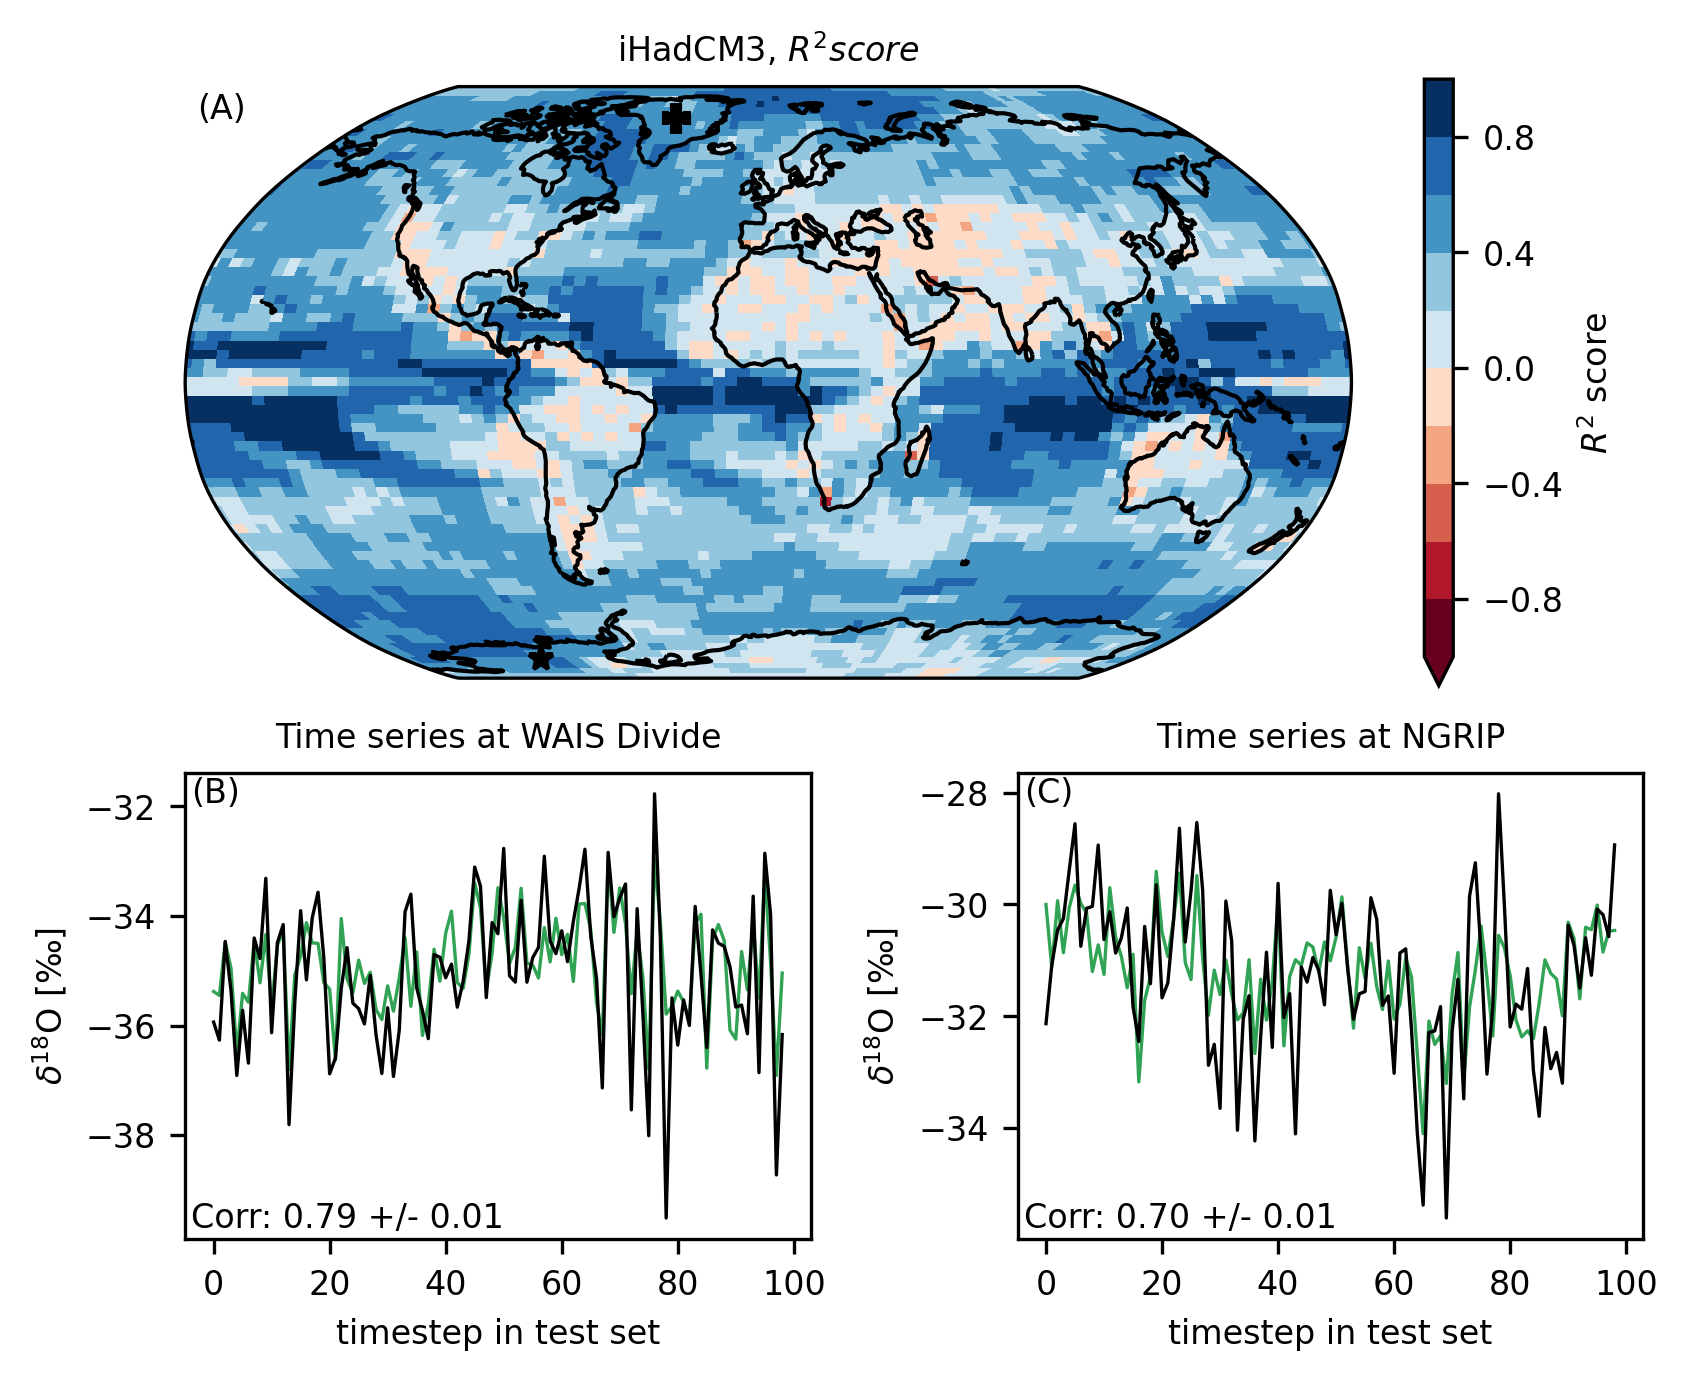

In [7]:
locs = np.array([[-79.5,-112.1],[75.1,-42.3]]) # ,[-75.1, 123.4],[-75.0, 0.1]])
locs[:,1] = locs[:,1]%360
locs_labels = ["WAIS Divide", "NGRIP"] # ,"EPICA - Concordia", "EPICA - Kohnen"]

n_rows = 2
n_cols = 2

map_height = 1.3
figure_width = textwidth
figure_height = textwidth * (n_rows-1+map_height) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize=[figure_width, figure_height])
gs = gridspec.GridSpec(2, 2, height_ratios=np.array([map_height,1]))

ax = fig.add_subplot(gs[0, :], projection=r2_style["PROJECTION"])

plot_map_markers(ax, locs, np.nanmean(r2_best,axis=(0,1)), descriptions_best[0]["DATASET_DESCRIPTION"], style=r2_style, 
            title=descriptions_best[0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+r", $R^2score$", locs_labels=locs_labels)
add_label_to_axes(ax, "({})".format(alphabet_letters[0]), std_style)

ax_ts1 = fig.add_subplot(gs[1, 0])
plot_timeseries(ax_ts1, data_pred=np.array(predictions_best), data_gt=gt_best[0], loc=locs[0,:], loc_label=locs_labels[0], description=descriptions_best[0]["DATASET_DESCRIPTION"], style=timeseries_style)
add_label_to_axes(ax_ts1, "({})".format(alphabet_letters[1]), std_style)

ax_ts2 = fig.add_subplot(gs[1, 1])
plot_timeseries(ax_ts2, data_pred=np.array(predictions_best), data_gt=gt_best[0], loc=locs[1,:], loc_label=locs_labels[1], description=descriptions_best[0]["DATASET_DESCRIPTION"], style=timeseries_style)
add_label_to_axes(ax_ts2, "({})".format(alphabet_letters[2]), std_style)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/iHadCM3_main_plot_default.jpg")
plt.savefig("Images/iHadCM3_main_plot_default.png")
plt.savefig("Images/iHadCM3_main_plot_default.pdf")
plt.savefig("Images/iHadCM3_main_plot_default.svg")

plt.show()

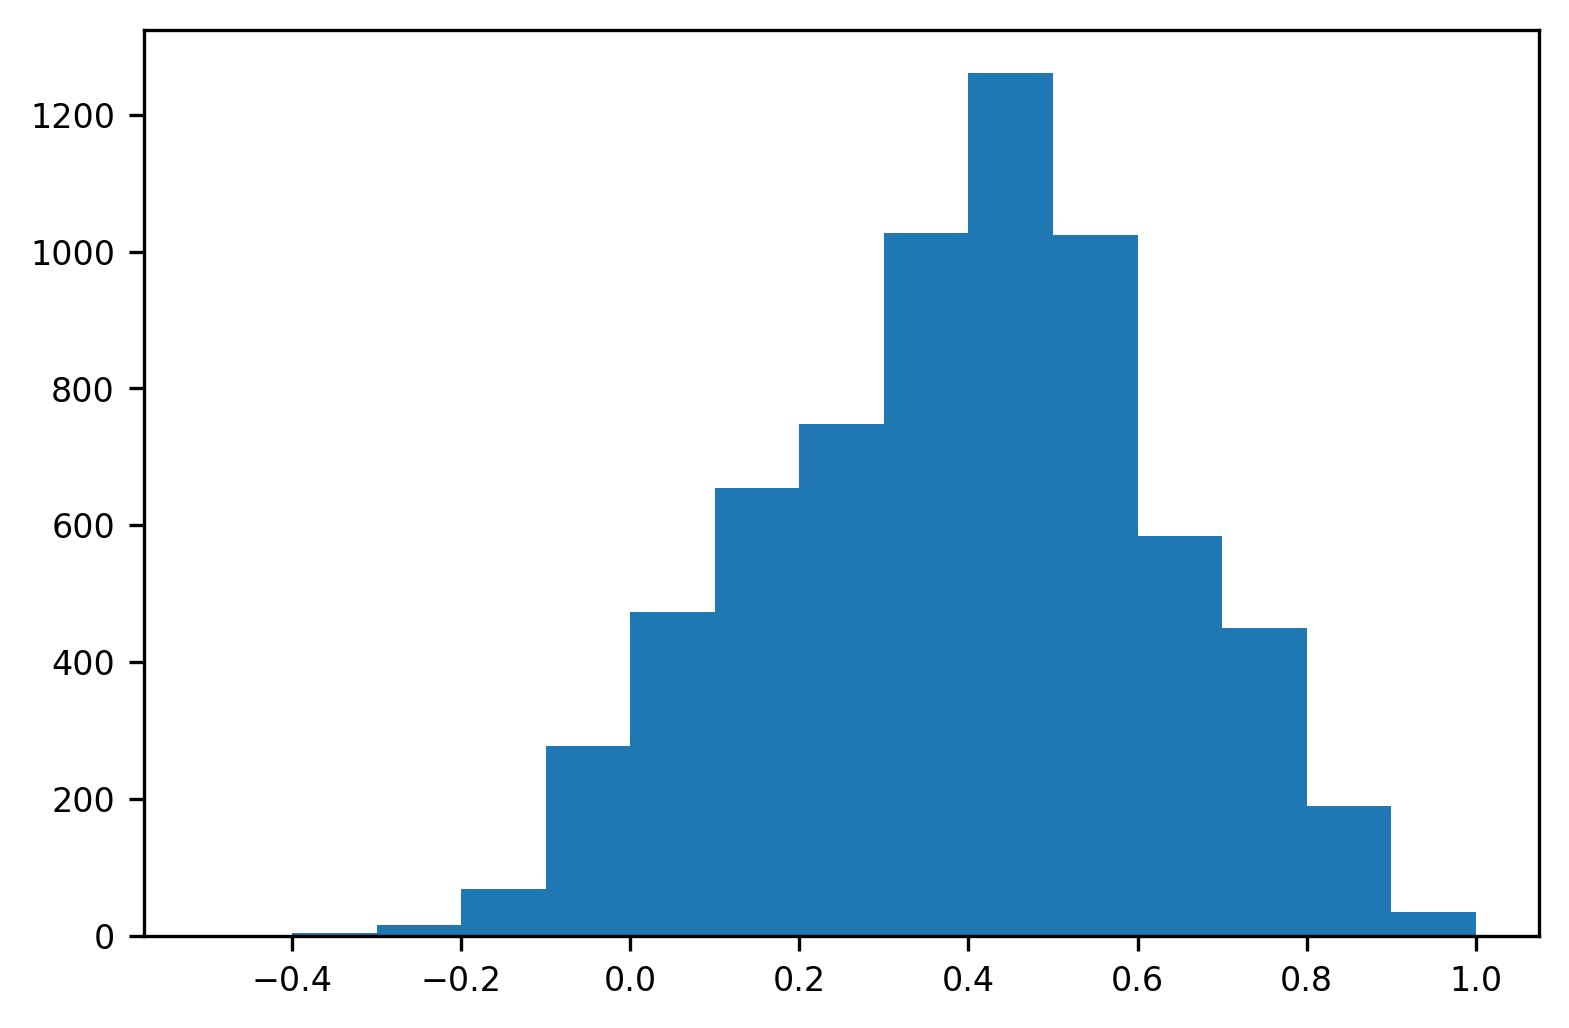

Fraction of grid boxes exceeding R2=0.6: 0.185
Fraction of grid boxes exceeding R2=0.8: 0.033
Fraction of grid boxes exceeding R2=0.0: 0.054


In [29]:
# How are r2 scores distributed?
gridbox_performances = np.nanmean(r2_best, axis=(0,1)).ravel()
plt.hist(gridbox_performances, bins=np.linspace(-0.5,1,16))
plt.show()
print("Fraction of grid boxes exceeding R2=0.6: {:.3f}".format((len(gridbox_performances[gridbox_performances > 0.6]))/len(gridbox_performances)))
print("Fraction of grid boxes exceeding R2=0.8: {:.3f}".format((len(gridbox_performances[gridbox_performances > 0.8]))/len(gridbox_performances)))
print("Fraction of grid boxes exceeding R2=0.0: {:.3f}".format((len(gridbox_performances[gridbox_performances <= 0]))/len(gridbox_performances)))

### Plot some sample anomalies.

In [36]:
import matplotlib.gridspec as gridspec

n_rows = 1
n_cols = 3

trainset_mean = get_trainset_mean(descriptions_best[0])
anom_gt = gt_best[0] - trainset_mean
anom_pred = predictions_best[0] - trainset_mean

In [37]:
# calculate anomaly correlation coefficient. Print mean over test set, use to pick timesteps from percentiles.
acc = np.squeeze(get_acc(anom_pred=anom_pred, anom_gt=anom_gt, dataset_description=descriptions_best[0]["DATASET_DESCRIPTION"]))

top_percentile = np.where(acc > np.percentile(acc,90))[0]
bottom_percentile = np.where(acc < np.percentile(acc,10))[0]
ts_median = np.where(acc == np.median(acc))[0][0]
ts_year = np.where(np.array(descriptions_best[0]["DATASET_DESCRIPTION"]["TIMESTEPS_TEST"]) == 1816)[0][0]  # if selecting a given year.

# randomly select one timestep from good and bad percentile.
np.random.seed(2)
ts_top = top_percentile[np.random.randint(len(top_percentile))]
ts_bottom = bottom_percentile[np.random.randint(len(bottom_percentile))]

ts = [ts_bottom, ts_median, ts_top, ts_year]
labels_anom = ["10th percentile", "Median", "90th percentile", "1816 CE"]

print("ACC: {:.3f} +/- {:.3f}".format(np.mean(acc), np.std(acc)))

ACC: 0.447 +/- 0.059


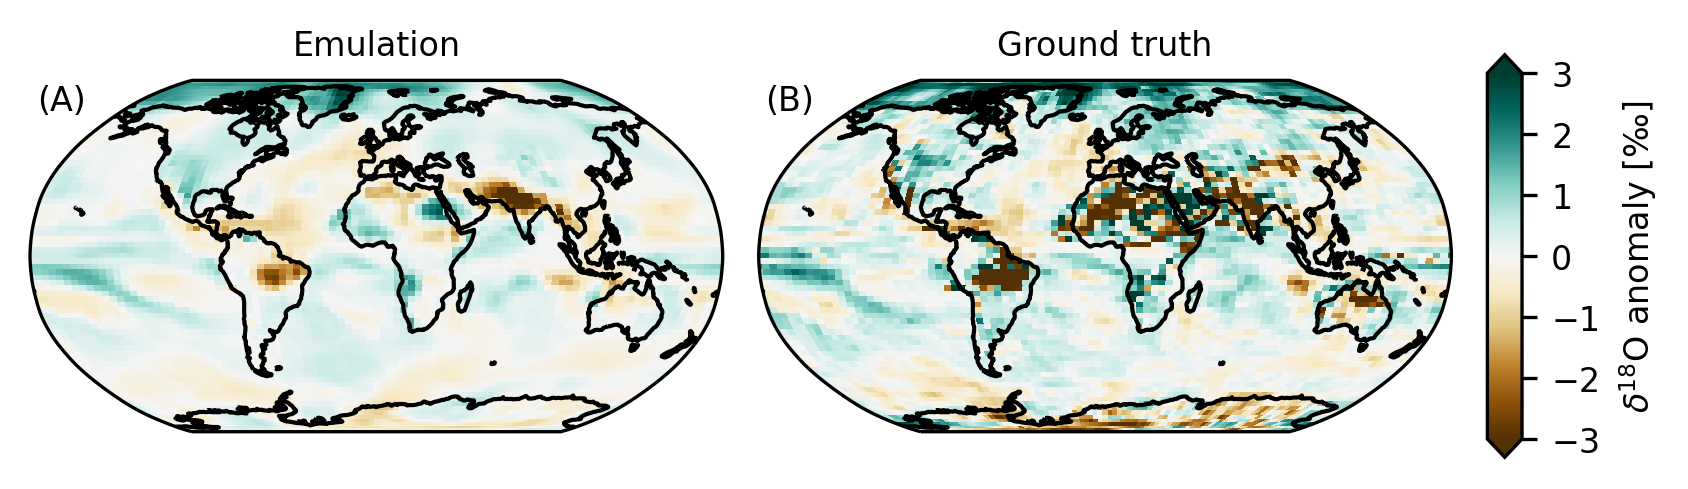

In [38]:
# in the regular paper just have a single anomaly difference - and then the whole 2x2 thing in the appendix.

n_rows = 1
n_cols = 2

figure_width = textwidth
figure_height = 0.8 * textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

ax_pred = fig.add_subplot(gs[0], projection= anom_style["PROJECTION"])
ax_gt = fig.add_subplot(gs[1], projection= anom_style["PROJECTION"])


plot_map(ax_pred, anom_pred[ts[1],0,...], descriptions_best[0]["DATASET_DESCRIPTION"], anom_style, 
    title="Emulation".format(labels_anom[1]), show_colorbar=False)  # "Emulation, time step {}".format(ts[i*n_cols+j]),
add_label_to_axes(ax_pred, "({})".format(alphabet_letters[0]), std_style)

plot_map(ax_gt, anom_gt[ts[1],0,...], descriptions_best[0]["DATASET_DESCRIPTION"], anom_style, 
    title="Ground truth".format(labels_anom[1]), show_colorbar=False)  # "Ground truth, time step {}".format(ts[i*n_cols+j]),
add_label_to_axes(ax_gt, "({})".format(alphabet_letters[1]), std_style)

ax_cb=plt.subplot(gs[:,n_cols])

cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=anom_style["CMAP"], norm=anom_style["NORM"]), cax=ax_cb, extend=anom_style["CBAR_EXTEND"])
cbar.set_label(anom_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/iHadCM3_anomalies_single.jpg")
plt.savefig("Images/iHadCM3_anomalies_single.png")
plt.savefig("Images/iHadCM3_anomalies_single.pdf")
plt.savefig("Images/iHadCM3_anomalies_single.svg")

plt.show()

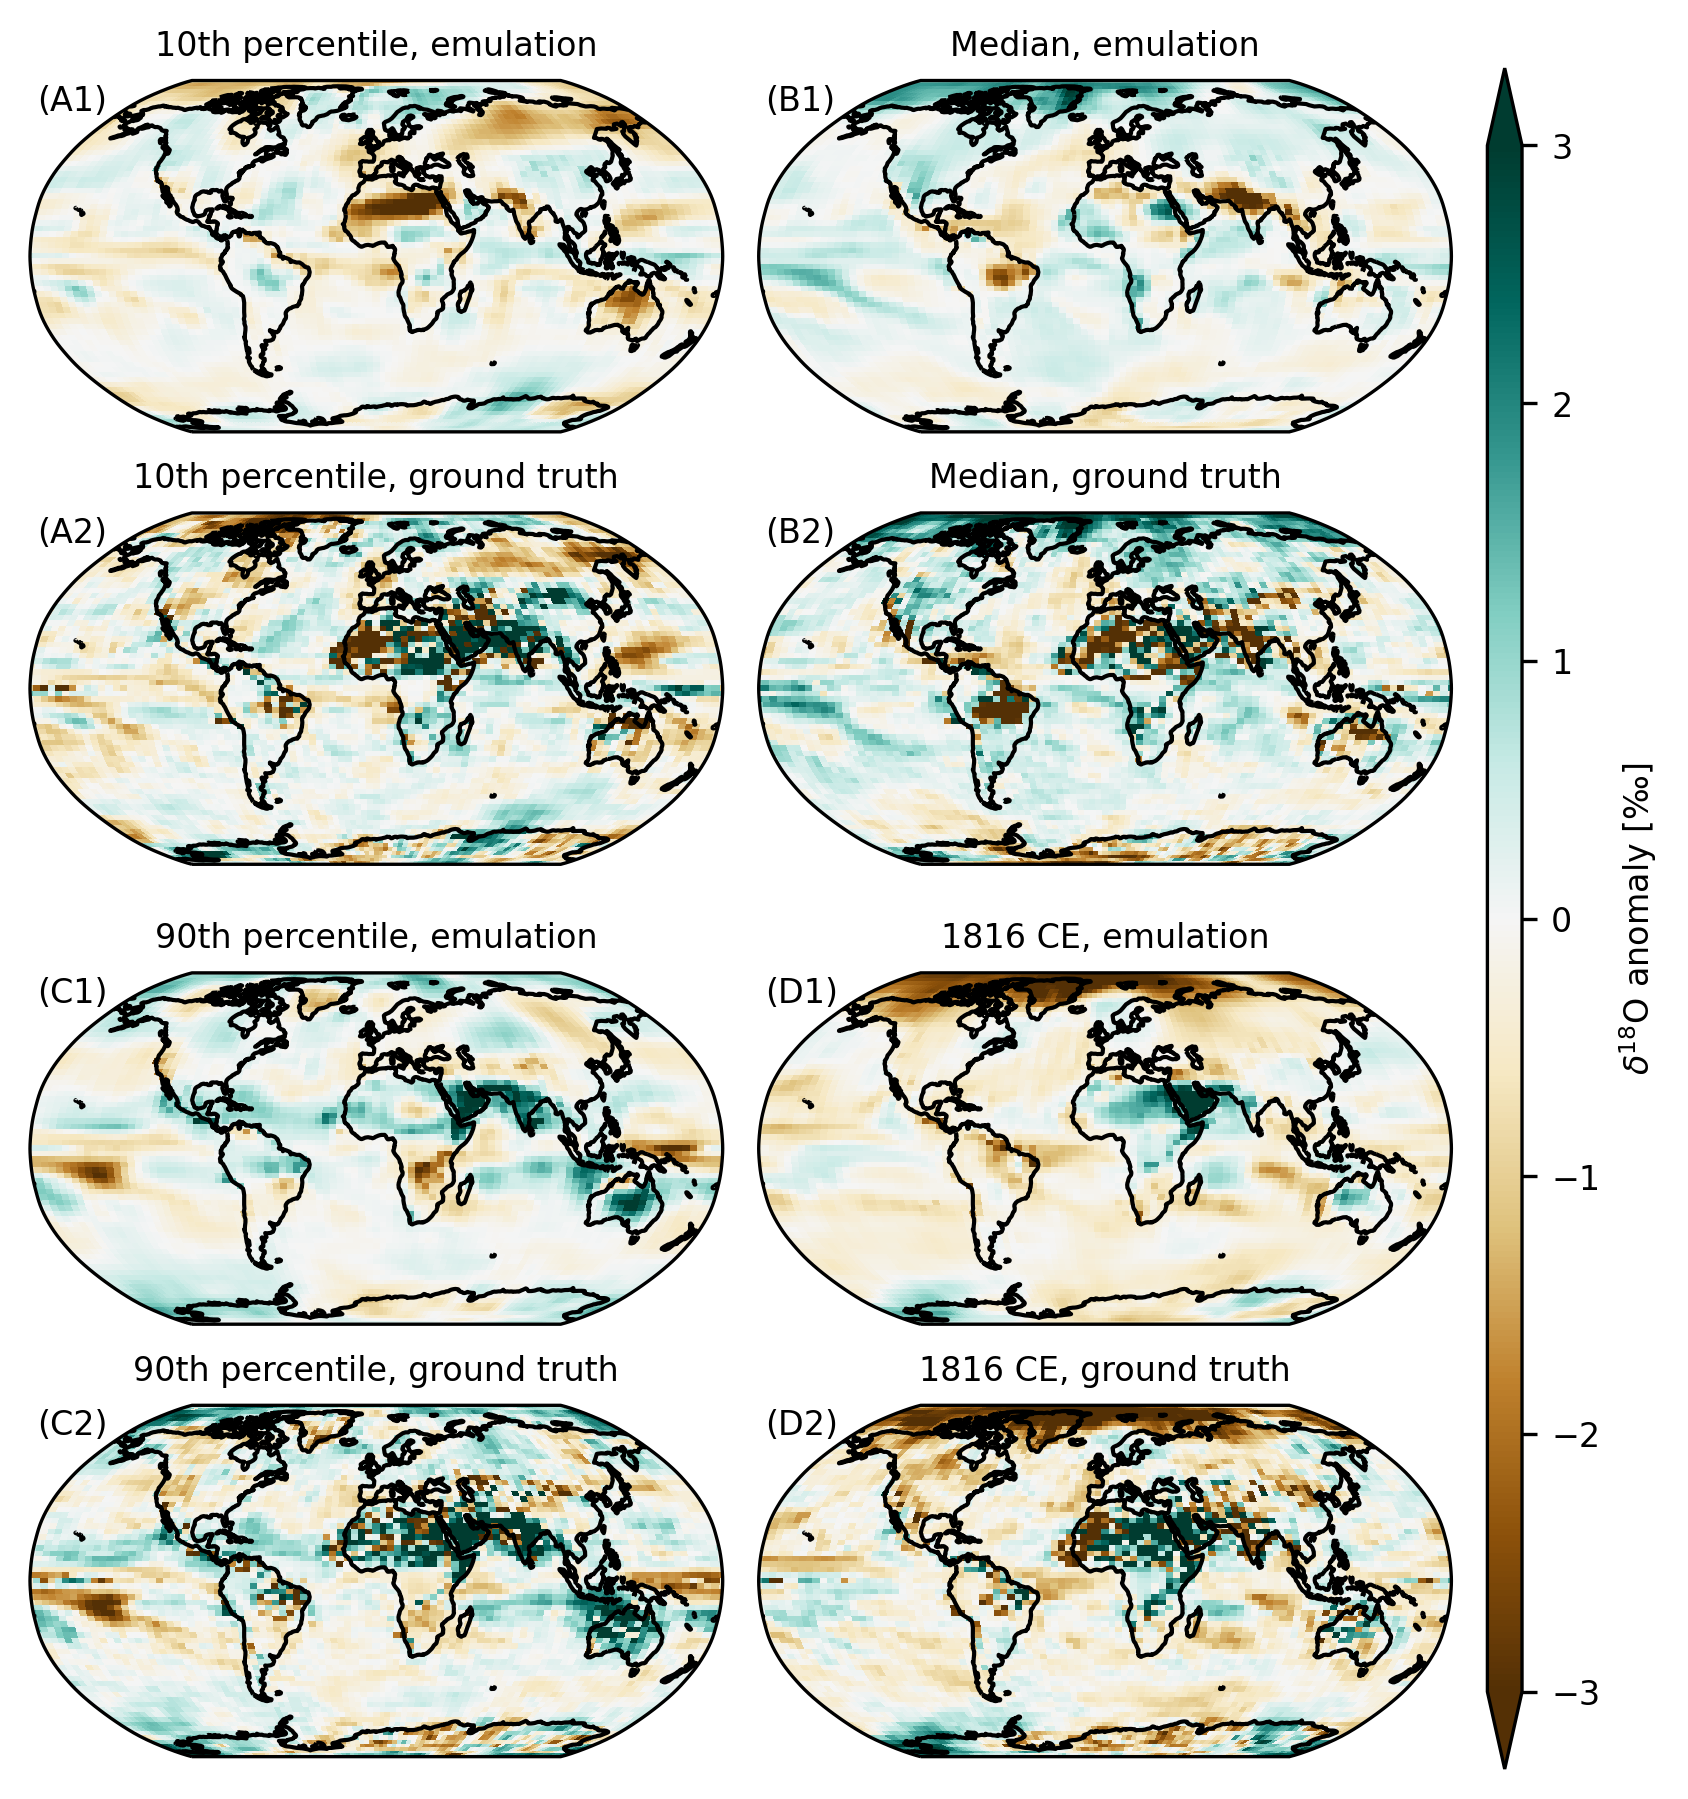

In [39]:
n_rows = 2
n_cols = 2

figure_width = textwidth
figure_height = 1.5* textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

for i in range(n_rows):
    for j in range(n_cols):
        gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[i,j], hspace=0.15)
        ax_gt = fig.add_subplot(gs00[1], projection= anom_style["PROJECTION"])        
        ax_pred = fig.add_subplot(gs00[0], projection= anom_style["PROJECTION"])
        plot_map(ax_gt, anom_gt[ts[i*n_cols+j],0,...], descriptions_best[0]["DATASET_DESCRIPTION"], anom_style, 
            title="{}, ground truth".format(labels_anom[i*n_cols+j]), show_colorbar=False)  # "Ground truth, time step {}".format(ts[i*n_cols+j]),
        add_label_to_axes(ax_pred, "({}1)".format(alphabet_letters[i*n_cols+j]), std_style)

        plot_map(ax_pred, anom_pred[ts[i*n_cols+j],0,...], descriptions_best[0]["DATASET_DESCRIPTION"], anom_style, 
            title="{}, emulation".format(labels_anom[i*n_cols+j]), show_colorbar=False)  # "Emulation, time step {}".format(ts[i*n_cols+j]),
        add_label_to_axes(ax_gt, "({}2)".format(alphabet_letters[i*n_cols+j]), std_style)

ax_cb=plt.subplot(gs[:,n_cols])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=anom_style["CMAP"], norm=anom_style["NORM"]), cax=ax_cb, extend=anom_style["CBAR_EXTEND"])
cbar.set_label(anom_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/iHadCM3_anomalies_all.jpg")
plt.savefig("Images/iHadCM3_anomalies_all.png")
plt.savefig("Images/iHadCM3_anomalies_all.pdf")
plt.savefig("Images/iHadCM3_anomalies_all.svg")

plt.show()

In [40]:
# Temperature anomaly in 1816:
tsurf_anomaly = get_testset(descriptions_best[0])["predictors"][:,0,...] - np.mean(get_testset(descriptions_best[0])["predictors"][:,0,...],axis=0)

Text(0.5, 1.0, '1816 simulated temperature anomaly')

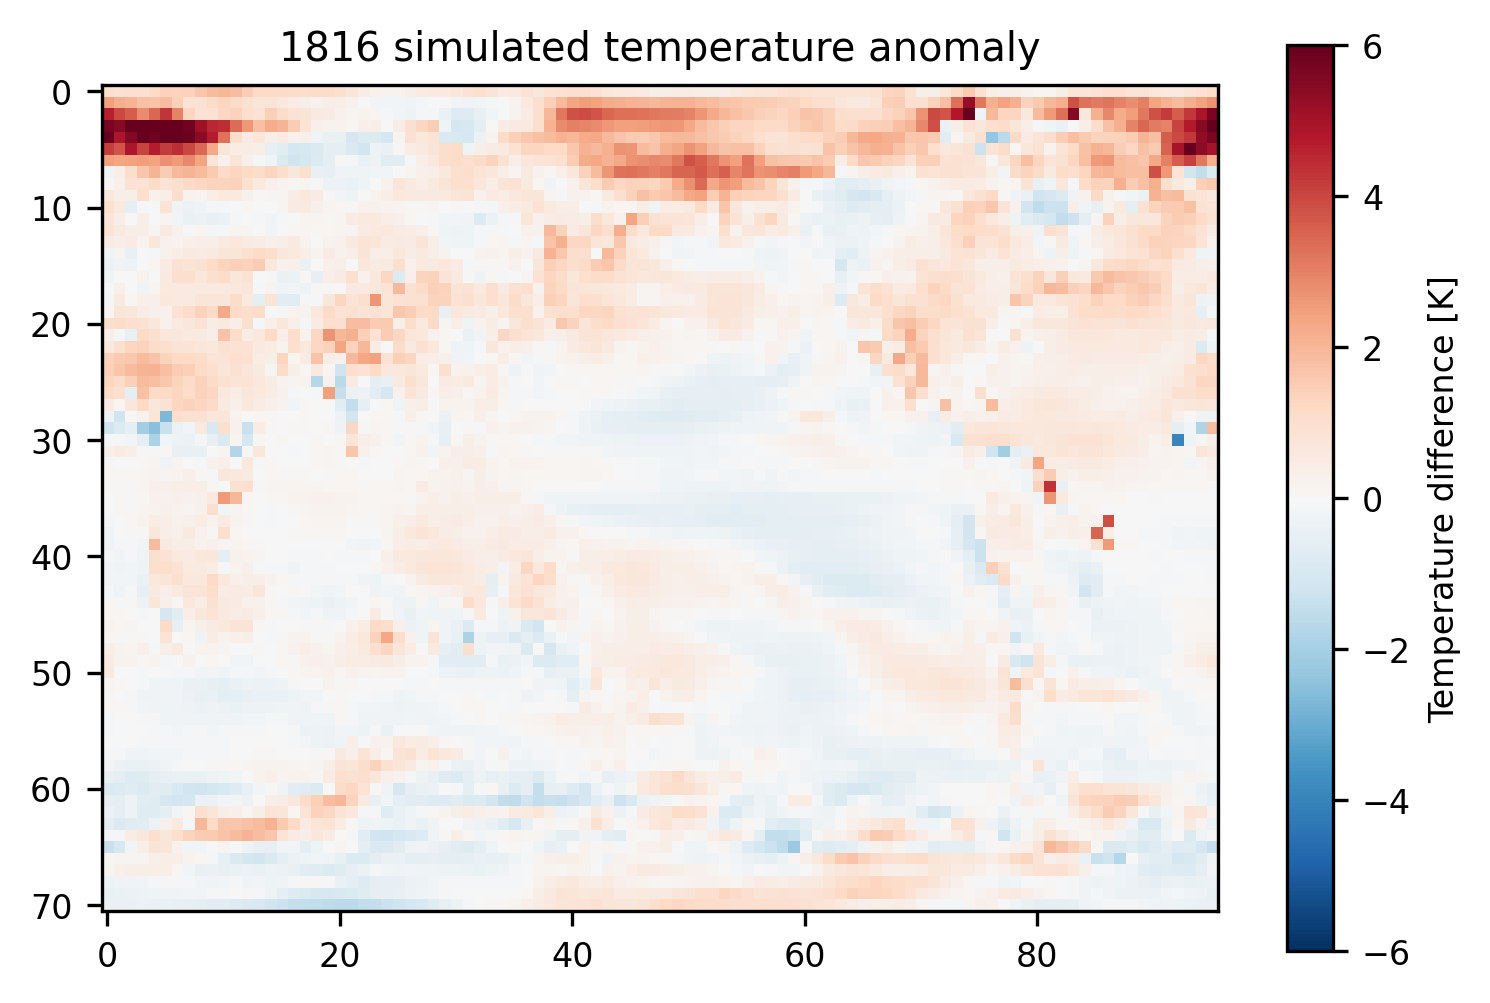

In [48]:
plt.imshow(tsurf_anomaly[ts[-1]], cmap="RdBu_r", vmin=-6, vmax=6)
plt.colorbar(label="Temperature difference [K]")
plt.title("1816 simulated temperature anomaly")

### Plot interpolation results.

In [20]:
# load flat model files
conditions_flat = {
    "DATASET_DESCRIPTION": {
                            "PRECIP_WEIGHTING" : False
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "FMAPS": (64,64,128,128),
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  }
}

descriptions_flat, predictions_flat, gt_flat, masks_flat = load_data_for_comparison("Output/Reproduce_new/", conditions_flat)
r2_flat_mean = np.zeros(len(predictions_flat))
r2_flat = np.zeros((len(predictions_flat), *predictions_flat[0].shape[1:]))

for i in range(len(predictions_flat)):
    r2_flat[i] = get_r2(predictions_flat[i], gt_flat[i])
    r2_flat_mean[i] = get_weighted_average(get_r2(predictions_flat[i], gt_flat[i]), descriptions_flat[i]["DATASET_DESCRIPTION"])

10 matching runs found


In [21]:
# load interpolated model files: Train with ico unet, interpolate to flat.
conditions_ico = {
    "DATASET_DESCRIPTION": {
                            "GRID_TYPE": "Flat",
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Ico",
                                  }
}
descriptions_ico, predictions_ico, gt_ico, masks_ico = load_data_for_comparison("Output/Reproduce_new/", conditions_ico)
predictions_ico = np.array(predictions_ico)[...,1:-1,:]

r2_interp_mean = np.zeros(len(predictions_ico))
r2_interp = np.zeros((len(predictions_ico), *predictions_ico[0].shape[1:]))

for i in range(len(predictions_ico)):
    r2_interp[i] = get_r2(predictions_ico[i], gt_ico[i])
    r2_interp_mean[i] = get_weighted_average(get_r2(predictions_ico[i], gt_ico[i]), descriptions_flat[i]["DATASET_DESCRIPTION"])

r2_interp = np.array(r2_interp)

10 matching runs found


In [22]:
# load twice interpolated gt
conditions_tw = {
    "DATASET_DESCRIPTION": {"RESULTS_INTERPOLATED": True,
                            "PRECIP_WEIGHTING" : False,
                            "GRID_TYPE": "Flat"
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  }
}

descriptions_tw, predictions_tw, gt_tw, masks_tw = load_data_for_comparison("Output/Reproduce_new/", conditions_tw)

predictions_tw = np.array(predictions_tw)[...,1:-1,:]
gt_tw = np.array(gt_tw)[...,1:-1,:]
masks_tw = np.array(masks_tw)[...,1:-1,:]

10 matching runs found


In [23]:
r2_tw_mean = np.zeros(len(predictions_tw))
r2_tw = np.zeros((len(predictions_tw), *predictions_tw[0].shape[1:]))

for i in range(len(predictions_tw)):
    r2_tw[i] = get_r2(predictions_tw[i], gt_flat[i])  # calculate wrt flat
    r2_tw_mean[i] = get_weighted_average(get_r2(predictions_tw[i], gt_flat[i]), descriptions_flat[i]["DATASET_DESCRIPTION"])

r2_tw = np.array(r2_tw)

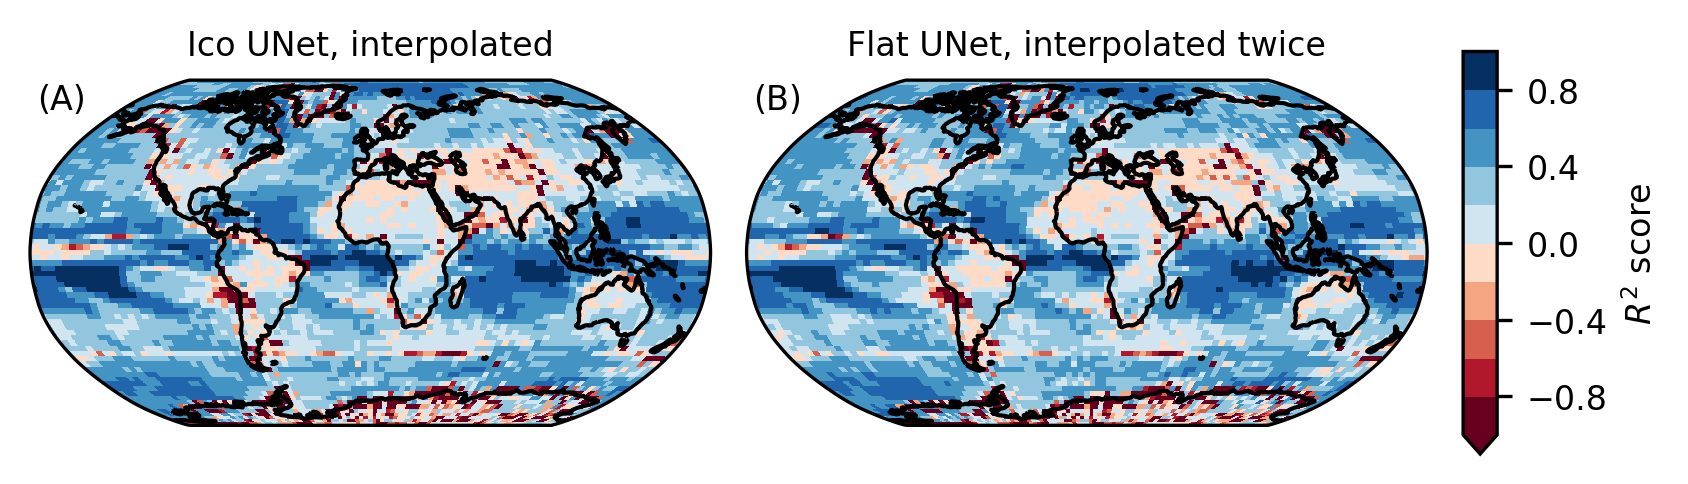

In [24]:
n_rows=1
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])


# ico unet interpolated to flat grid:
ax_1 = fig.add_subplot(gs[0], projection= r2_style["PROJECTION"])  
plot_map(ax_1, np.mean(r2_interp,axis=(0,1)), descriptions_flat[0]["DATASET_DESCRIPTION"], r2_style, 
            title="Ico UNet, interpolated", show_colorbar=False)
add_label_to_axes(ax_1, "({})".format(alphabet_letters[0]), r2_style)

# ico interpolated to flat grid:
ax_2 = fig.add_subplot(gs[1], projection= r2_style["PROJECTION"])  
plot_map(ax_2, np.mean(r2_tw,axis=(0,1)), descriptions_flat[0]["DATASET_DESCRIPTION"], r2_style, 
            title="Flat UNet, interpolated twice", show_colorbar=False)
add_label_to_axes(ax_2, "({})".format(alphabet_letters[1]), r2_style)

ax_cb=plt.subplot(gs[2])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=r2_style["CMAP"], norm=r2_style["NORM"]), cax=ax_cb, extend=r2_style["CBAR_EXTEND"])
cbar.set_label(r2_style["CBAR_LABEL"])


fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/results_unets_on_flat_grid.jpg")
plt.savefig("Images/results_unets_on_flat_grid.png")
plt.savefig("Images/results_unets_on_flat_grid.pdf")
plt.savefig("Images/results_unets_on_flat_grid.svg")
plt.show()

### Plot differences UNet-baseline:

In [8]:
unet_modified_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "PRECIP_WEIGHTING" : False,
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "LEARNING_RATE": 1e-3,
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  "DEPTH": 3,
                                  "FMAPS": (32,32,64,64)}
}

flat_baseline_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "PCA_Flat", "REGTYPE": "linreg"}
}


ico_unet_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "GRID_TYPE": "Ico"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Ico",
                                  "LEARNING_RATE": 1e-3}
}

ico_baseline_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "GRID_TYPE": "Ico"},
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "PCA_Ico",
                                   "REGTYPE": "linreg"}
}

In [9]:
descriptions_m_flat, predictions_m_flat, gt_m_flat, masks_m_flat = load_data_for_comparison("Output/Reproduce_new/", unet_modified_c, keywords_blacklist=["RESULTS_INTERPOLATED"])
descriptions_ico, predictions_ico, gt_ico, masks_ico = load_data_for_comparison("Output/Reproduce_new/", ico_unet_c)

descriptions_bl_flat, predictions_bl_flat, gt_bl_flat, masks_bl_flat = load_data_for_comparison("Output/Reproduce_new/", flat_baseline_c)
descriptions_bl_ico, predictions_bl_ico, gt_bl_ico, masks_bl_ico = load_data_for_comparison("Output/Reproduce_new/", ico_baseline_c)


10 matching runs found
10 matching runs found
1 matching runs found
1 matching runs found


In [10]:
# modified flat UNet
r2_m_flat_mean = np.zeros(len(predictions_m_flat))
r2_m_flat = np.zeros((len(predictions_m_flat), *predictions_m_flat[0].shape[1:]))

for i in range(len(predictions_m_flat)):
    r2_m_flat[i] = get_r2(predictions_m_flat[i], gt_m_flat[i])
    r2_m_flat_mean[i] = get_weighted_average(get_r2(predictions_m_flat[i], gt_m_flat[i]), descriptions_m_flat[i]["DATASET_DESCRIPTION"])

r2_m_flat = np.array(r2_m_flat)

# ico unet
r2_ico_mean = np.zeros(len(predictions_ico))
r2_ico = np.zeros((len(predictions_ico), *predictions_ico[0].shape[1:]))

for i in range(len(predictions_ico)):
    r2_ico[i] = get_r2(predictions_ico[i], gt_ico[i])
    r2_ico_mean[i] =np.mean(get_r2(predictions_ico[i], gt_ico[i]), axis=(1,2))

r2_ico = np.array(r2_ico)

# ico baseline
r2_bl_ico_mean = np.zeros(len(predictions_bl_ico))
r2_bl_ico = np.zeros((len(predictions_bl_ico), *predictions_bl_ico[0].shape[1:]))

for i in range(len(predictions_bl_ico)):
    r2_bl_ico[i] = get_r2(predictions_bl_ico[i], gt_bl_ico[i])
    r2_bl_ico_mean[i] = np.mean(get_r2(predictions_bl_ico[i], gt_bl_ico[i]), axis=(1,2))

r2_bl_ico = np.array(r2_bl_ico)

# flat baseline
r2_bl_flat_mean = np.zeros(len(predictions_bl_flat))
r2_bl_flat = np.zeros((len(predictions_bl_flat), *predictions_bl_flat[0].shape[1:]))

for i in range(len(predictions_bl_flat)):
    r2_bl_flat[i] = get_r2(predictions_bl_flat[i], gt_bl_flat[i])
    r2_bl_flat_mean[i] = get_weighted_average(get_r2(predictions_bl_flat[i], gt_bl_flat[i]), descriptions_bl_flat[i]["DATASET_DESCRIPTION"])

r2_bl_ico = np.array(r2_bl_ico)

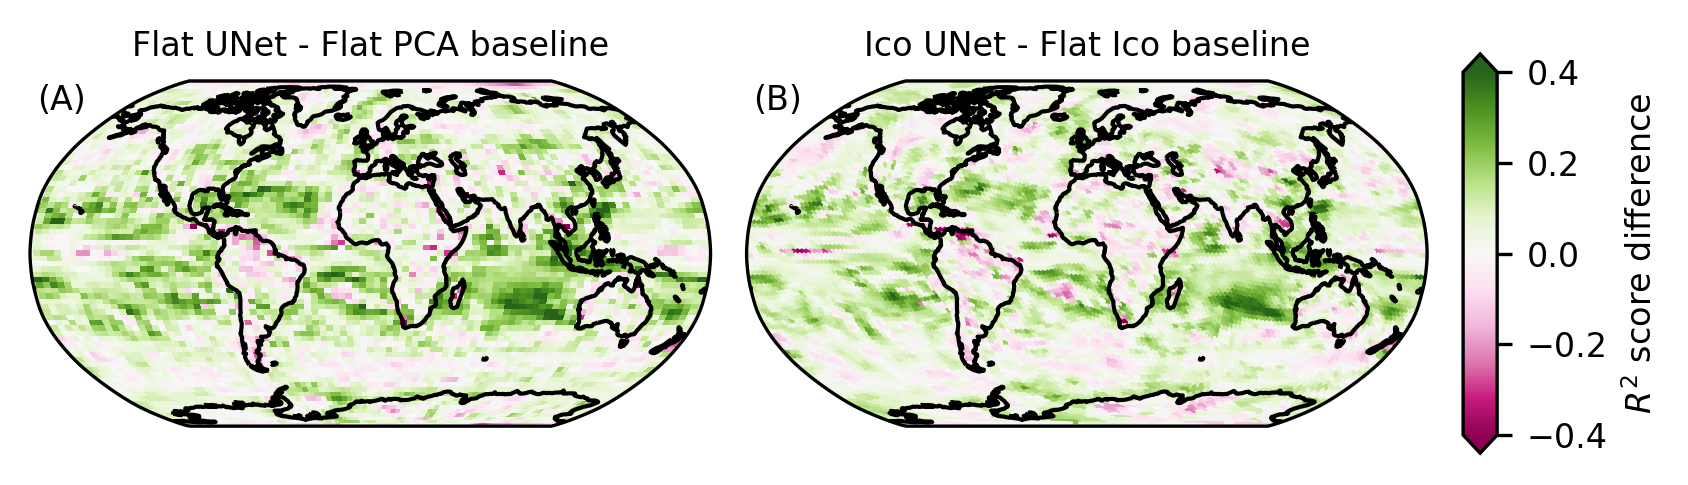

In [74]:
n_rows=1
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])


# originally on flat grid:
ax_1 = fig.add_subplot(gs[0], projection= diff_style["PROJECTION"])  
plot_map(ax_1, np.mean(r2_m_flat,axis=(0,1))-np.mean(r2_bl_flat,axis=(0,1)), descriptions_m_flat[0]["DATASET_DESCRIPTION"], diff_style, 
            title="Flat UNet - Flat PCA baseline", show_colorbar=False)
add_label_to_axes(ax_1, "({})".format(alphabet_letters[0]), diff_style)

# ico unet interpolated to flat grid:
ax_2 = fig.add_subplot(gs[1], projection= diff_style["PROJECTION"])  
plot_ico_map(ax_2, np.mean(r2_ico,axis=(0,1)).ravel()-np.mean(r2_bl_ico,axis=(0,1)).ravel(), descriptions_ico[0]["DATASET_DESCRIPTION"], diff_style, 
            title="Ico UNet - Flat Ico baseline", show_colorbar=False)
add_label_to_axes(ax_2, "({})".format(alphabet_letters[1]), diff_style)

ax_cb=plt.subplot(gs[2])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=diff_style["CMAP"], norm=diff_style["NORM"]), cax=ax_cb, extend=diff_style["CBAR_EXTEND"])
cbar.set_label(diff_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/differences_to_baselines.jpg")
plt.savefig("Images/differences_to_baselines.png")
plt.savefig("Images/differences_to_baselines.pdf")
plt.savefig("Images/differences_to_baselines.svg")
plt.show()

### Plot diff variables.

In [75]:
unet_tsurf_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"]},
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "LEARNING_RATE": 1e-3,
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  "DEPTH": 3,
                                  "FMAPS": (32,32,64,64)}
}

unet_prec_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"prec": ["prec"]},
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "LEARNING_RATE": 1e-3,
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  "DEPTH": 3,
                                  "FMAPS": (32,32,64,64)}
}

In [76]:
descriptions_tsurf, predictions_tsurf, gt_tsurf, masks_tsurf = load_data_for_comparison("Output/Reproduce_new/", unet_tsurf_c)
descriptions_prec, predictions_prec, gt_prec, masks_prec = load_data_for_comparison("Output/Reproduce_new/", unet_prec_c)

# tsurf
r2_tsurf_mean = np.zeros(len(predictions_tsurf))
r2_tsurf = np.zeros((len(predictions_tsurf), *predictions_tsurf[0].shape[1:]))

for i in range(len(predictions_tsurf)):
    r2_tsurf[i] = get_r2(predictions_tsurf[i], gt_tsurf[i])
    r2_tsurf_mean[i] = get_weighted_average(get_r2(predictions_tsurf[i], gt_tsurf[i]), descriptions_tsurf[i]["DATASET_DESCRIPTION"])

r2_tsurf = np.array(r2_tsurf)

# prec
r2_prec_mean = np.zeros(len(predictions_prec))
r2_prec = np.zeros((len(predictions_prec), *predictions_prec[0].shape[1:]))

for i in range(len(predictions_prec)):
    r2_prec[i] = get_r2(predictions_prec[i], gt_prec[i])
    r2_prec_mean[i] = get_weighted_average(get_r2(predictions_prec[i], gt_prec[i]), descriptions_prec[i]["DATASET_DESCRIPTION"])

r2_prec = np.array(r2_prec)

10 matching runs found
10 matching runs found


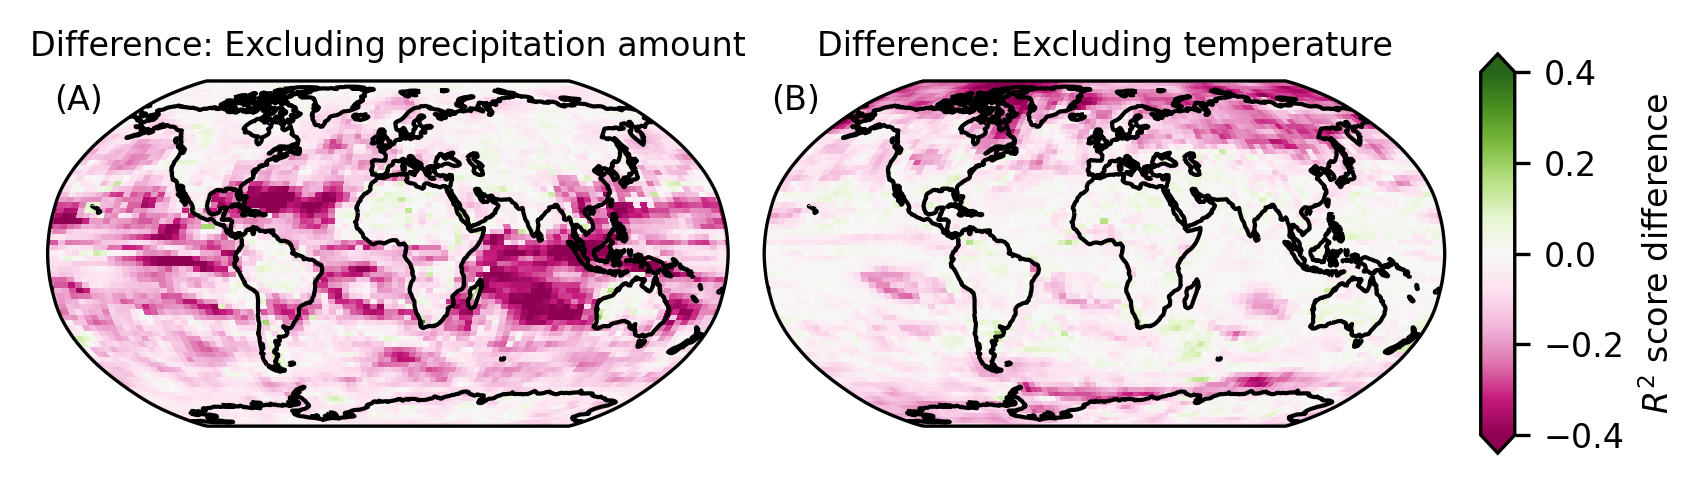

In [77]:
n_rows=1
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

# tsurf - both:
ax_1 = fig.add_subplot(gs[0], projection=diff_style["PROJECTION"])  
plot_map(ax_1, np.mean(r2_tsurf,axis=(0,1))-np.mean(r2_m_flat,axis=(0,1)), descriptions_m_flat[0]["DATASET_DESCRIPTION"], diff_style, 
            title="Difference: Excluding precipitation amount", show_colorbar=False)
add_label_to_axes(ax_1, "({})".format(alphabet_letters[0]), diff_style)

# prec - both:
ax_2 = fig.add_subplot(gs[1], projection=diff_style["PROJECTION"])  
plot_map(ax_2, np.mean(r2_prec,axis=(0,1))-np.mean(r2_m_flat,axis=(0,1)), descriptions_m_flat[0]["DATASET_DESCRIPTION"], diff_style, 
            title="Difference: Excluding temperature", show_colorbar=False)
add_label_to_axes(ax_2, "({})".format(alphabet_letters[1]), diff_style)

ax_cb=plt.subplot(gs[2])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=diff_style["CMAP"], norm=diff_style["NORM"]), cax=ax_cb, extend=diff_style["CBAR_EXTEND"])
cbar.set_label(diff_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/differences_variables.jpg")
plt.savefig("Images/differences_variables.png")
plt.savefig("Images/differences_variables.pdf")
plt.savefig("Images/differences_variables.svg")
plt.show()

### Tweaks to flat architecture:

In [4]:
#Tweaks to flat architecture:

unet_unmodified_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "PRECIP_WEIGHTING" : False,
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": False,
                                  "USE_CYLINDRICAL_PADDING": False,
                                  "LEARNING_RATE": 1e-3,
                                  "LOSS": "Masked_MSELoss",
                                  "DEPTH": 3,
                                  "FMAPS": (32,32,64,64)}
}

unet_loss_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "PRECIP_WEIGHTING" : False,
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": False,
                                  "USE_CYLINDRICAL_PADDING": False,
                                  "LEARNING_RATE": 1e-3,
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  "DEPTH": 3,
                                  "FMAPS": (32,32,64,64)}
}

unet_coordconv_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "PRECIP_WEIGHTING" : False,
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": False,
                                  "LEARNING_RATE": 1e-3,
                                  "LOSS": "Masked_MSELoss",
                                  "DEPTH": 3,
                                  "FMAPS": (32,32,64,64)}
}

unet_padding_c = {
    "DATASET_DESCRIPTION": {"PREDICTOR_VARIABLES" : {"tsurf": ["tsurf"],
                                                     "prec": ["prec"]},
                            "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                            "PRECIP_WEIGHTING" : False,
                            "GRID_TYPE": "Flat"
                                       },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": False,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "LEARNING_RATE": 1e-3,
                                  "LOSS": "Masked_MSELoss",
                                  "DEPTH": 3,
                                  "FMAPS": (32,32,64,64)}
}

In [5]:
descriptions_unmodified, predictions_unmodified, gt_unmodified, masks_unmodified = load_data_for_comparison("Output/Reproduce_new/", unet_unmodified_c)
descriptions_loss, predictions_loss, gt_loss, masks_loss = load_data_for_comparison("Output/Reproduce_new/", unet_loss_c)
descriptions_coordconv, predictions_coordconv, gt_coordconv, masks_coordconv = load_data_for_comparison("Output/Reproduce_new/", unet_coordconv_c)
descriptions_padding, predictions_padding, gt_padding, masks_padding = load_data_for_comparison("Output/Reproduce_new/", unet_padding_c)

10 matching runs found
10 matching runs found
10 matching runs found
10 matching runs found


In [6]:
# unmodified
r2_unmodified_mean = np.zeros(len(predictions_unmodified))
r2_unmodified = np.zeros((len(predictions_unmodified), *predictions_unmodified[0].shape[1:]))

for i in range(len(predictions_unmodified)):
    r2_unmodified[i] = get_r2(predictions_unmodified[i], gt_unmodified[i])
    r2_unmodified_mean[i] = get_weighted_average(get_r2(predictions_unmodified[i], gt_unmodified[i]), descriptions_unmodified[i]["DATASET_DESCRIPTION"])

r2_unmodified = np.array(r2_unmodified)

# loss
r2_loss_mean = np.zeros(len(predictions_loss))
r2_loss = np.zeros((len(predictions_loss), *predictions_loss[0].shape[1:]))

for i in range(len(predictions_loss)):
    r2_loss[i] = get_r2(predictions_loss[i], gt_loss[i])
    r2_loss_mean[i] = get_weighted_average(get_r2(predictions_loss[i], gt_loss[i]), descriptions_loss[i]["DATASET_DESCRIPTION"])

r2_loss = np.array(r2_loss)

# coordconv
r2_coordconv_mean = np.zeros(len(predictions_coordconv))
r2_coordconv = np.zeros((len(predictions_coordconv), *predictions_coordconv[0].shape[1:]))

for i in range(len(predictions_coordconv)):
    r2_coordconv[i] = get_r2(predictions_coordconv[i], gt_coordconv[i])
    r2_coordconv_mean[i] = get_weighted_average(get_r2(predictions_coordconv[i], gt_coordconv[i]), descriptions_coordconv[i]["DATASET_DESCRIPTION"])

r2_coordconv = np.array(r2_coordconv)

# padding
r2_padding_mean = np.zeros(len(predictions_padding))
r2_padding = np.zeros((len(predictions_padding), *predictions_padding[0].shape[1:]))

for i in range(len(predictions_padding)):
    r2_padding[i] = get_r2(predictions_padding[i], gt_padding[i])
    r2_padding_mean[i] = get_weighted_average(get_r2(predictions_padding[i], gt_padding[i]), descriptions_padding[i]["DATASET_DESCRIPTION"])

r2_padding = np.array(r2_padding)


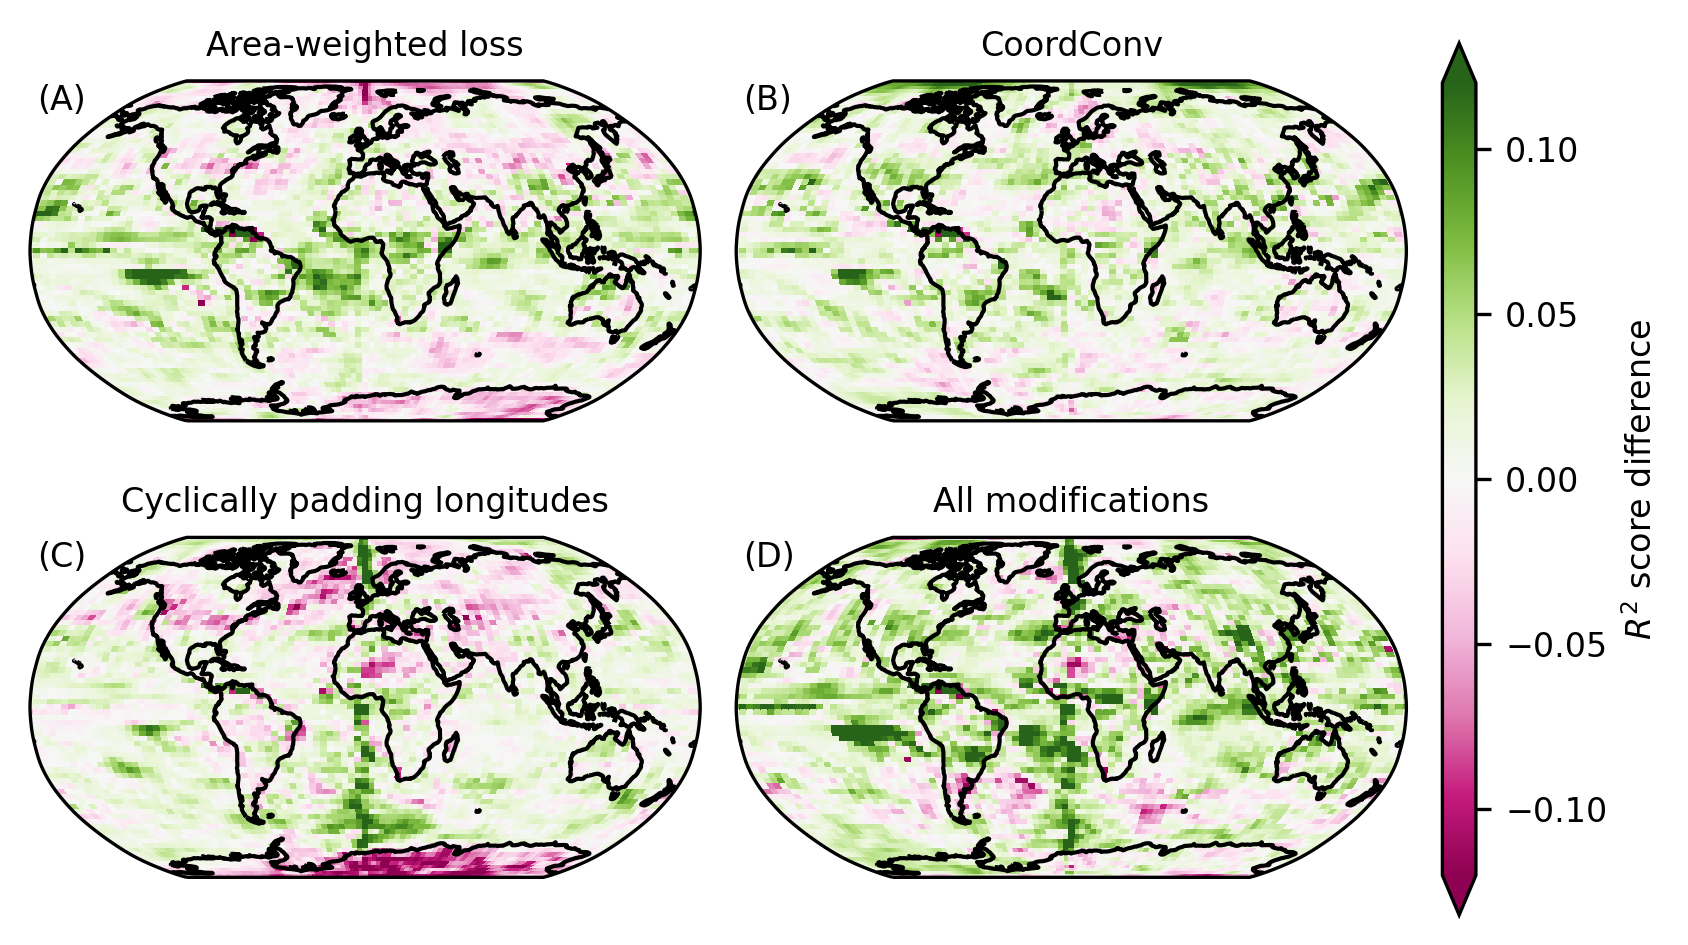

In [11]:
n_rows=2
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows) / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

# loss
ax_1 = fig.add_subplot(gs[0,0], projection=diff_fine_style["PROJECTION"])  
plot_map(ax_1, np.mean(r2_loss,axis=(0,1))-np.mean(r2_unmodified,axis=(0,1)), descriptions_unmodified[0]["DATASET_DESCRIPTION"], diff_fine_style, 
            title="Area-weighted loss", show_colorbar=False)
add_label_to_axes(ax_1, "({})".format(alphabet_letters[0]), diff_fine_style)

# coord conv
ax_2 = fig.add_subplot(gs[0,1], projection=diff_fine_style["PROJECTION"])  
plot_map(ax_2, np.mean(r2_coordconv,axis=(0,1))-np.mean(r2_unmodified,axis=(0,1)), descriptions_unmodified[0]["DATASET_DESCRIPTION"], diff_fine_style, 
            title="CoordConv", show_colorbar=False)
add_label_to_axes(ax_2, "({})".format(alphabet_letters[1]), diff_fine_style)

# padding
ax_3 = fig.add_subplot(gs[1,0], projection=diff_fine_style["PROJECTION"])  
plot_map(ax_3, np.mean(r2_padding,axis=(0,1))-np.mean(r2_unmodified,axis=(0,1)), descriptions_unmodified[0]["DATASET_DESCRIPTION"], diff_fine_style, 
            title="Cyclically padding longitudes", show_colorbar=False)
add_label_to_axes(ax_3, "({})".format(alphabet_letters[2]), diff_fine_style)

# all
ax_4 = fig.add_subplot(gs[1,1], projection=diff_fine_style["PROJECTION"])  
plot_map(ax_4, np.mean(r2_m_flat,axis=(0,1))-np.mean(r2_unmodified,axis=(0,1)), descriptions_unmodified[0]["DATASET_DESCRIPTION"], diff_fine_style, 
            title="All modifications", show_colorbar=False)
add_label_to_axes(ax_4, "({})".format(alphabet_letters[3]), diff_fine_style)

ax_cb=plt.subplot(gs[:,n_cols])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=diff_fine_style["CMAP"], norm=diff_fine_style["NORM"]), cax=ax_cb, extend=diff_fine_style["CBAR_EXTEND"])
cbar.set_label(diff_fine_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/modifications_flat_unet.jpg")
plt.savefig("Images/modifications_flat_unet.png")
plt.savefig("Images/modifications_flat_unet.pdf")
plt.savefig("Images/modifications_flat_unet.svg")
plt.show()

## Plot Crossprediction results

In [36]:
conditions = dict()
conditions["iHadCM3"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "iHadCM3",
                                "TARGET_VARIABLES": {'isotopes': ['d18O']}
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["ECHAM5"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "ECHAM5",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["isoGSM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "isoGSM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["iCESM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "iCESM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }


In [37]:
r2_means = []
r2s = []

for label, c in conditions.items():
    descriptions, predictions, gt, masks = load_data_for_comparison(output_folder, c)
    r2s.append([])
    r2_means.append([])
    for i in range(len(gt)):
        mask = np.logical_or(masks[i], np.isnan(gt[i]))
        r2s[-1].append(get_r2(predictions[i], gt[i], mask)[0])
        r2_means[-1].append(get_weighted_average(get_r2(predictions[i], gt[i], mask), descriptions[i]["DATASET_DESCRIPTION"]))


10 matching runs found
10 matching runs found
10 matching runs found
10 matching runs found


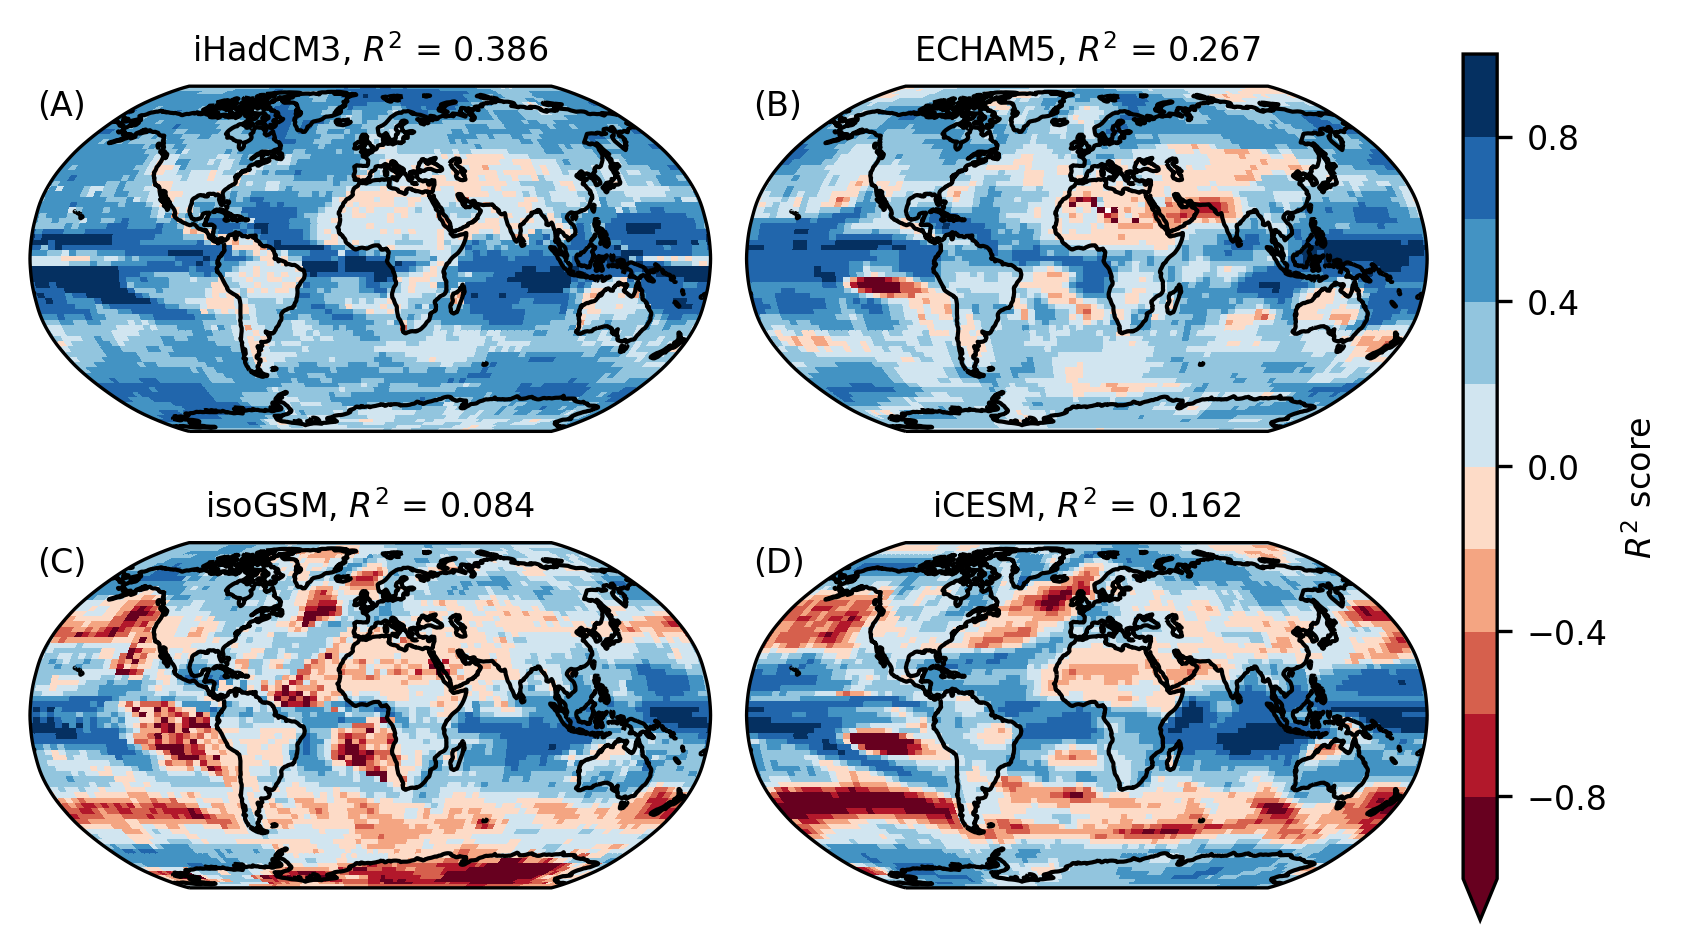

In [38]:
n_rows=2
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows) / \
    (n_cols) / r2_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

for i, key in enumerate(list(conditions.keys())):
    ax = fig.add_subplot(gs[i//2,i%2], projection=diff_fine_style["PROJECTION"])  
    plot_map(ax, np.mean(np.array(r2s[i]),axis=0), descriptions[0]["DATASET_DESCRIPTION"], r2_style, 
             title=key + r", $R^2$ = {:.3f}".format(np.mean(r2_means[i])), show_colorbar=False)
    add_label_to_axes(ax, "({})".format(alphabet_letters[i]), r2_style)

# fig.suptitle("UNet crossprediction", fontsize=10)


ax_cb=plt.subplot(gs[:,n_cols])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=r2_style["CMAP"], norm=r2_style["NORM"]), cax=ax_cb, extend=r2_style["CBAR_EXTEND"])
cbar.set_label(r2_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/crossprediction.pdf")
plt.savefig("Images/crossprediction.png")
plt.savefig("Images/crossprediction.jpg")
plt.savefig("Images/crossprediction.svg")

plt.show()

In [39]:
conditions_lr = dict()
conditions_lr["iHadCM3"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "iHadCM3",
                                "TARGET_VARIABLES": {'isotopes': ['d18O']}
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "LinReg_Pixelwise"}
    }
conditions_lr["ECHAM5"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "ECHAM5",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "LinReg_Pixelwise"}
    }
conditions_lr["isoGSM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "isoGSM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "LinReg_Pixelwise"}
    }
conditions_lr["iCESM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "iCESM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "LinReg_Pixelwise"}
    }


In [40]:
r2_means = []
r2s = []

for label, c in conditions_lr.items():
    descriptions, predictions, gt, masks = load_data_for_comparison(output_folder, c)
    r2s.append([])
    r2_means.append([])
    for i in range(len(gt)):
        mask = np.logical_or(masks[i], np.isnan(gt[i]))
        r2s[-1].append(get_r2(predictions[i], gt[i], mask)[0])
        r2_means[-1].append(get_weighted_average(get_r2(predictions[i], gt[i], mask), descriptions[i]["DATASET_DESCRIPTION"]))

1 matching runs found
1 matching runs found
1 matching runs found
1 matching runs found


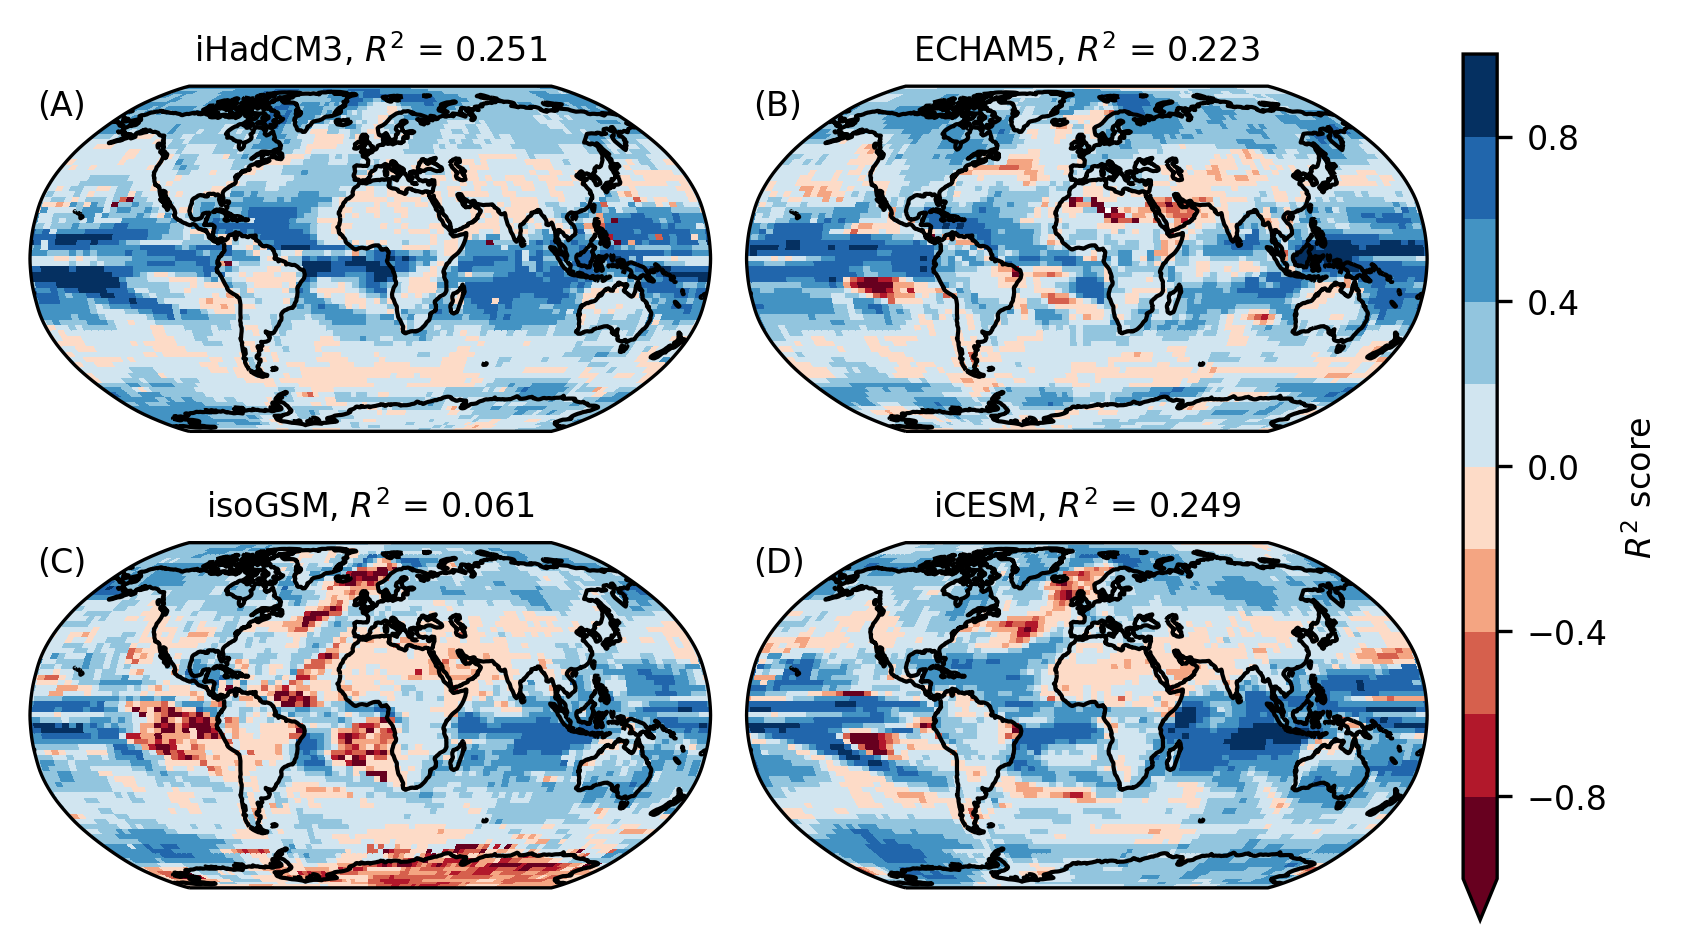

In [41]:
n_rows=2
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows) / \
    (n_cols) / r2_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

for i, key in enumerate(list(conditions.keys())):
    ax = fig.add_subplot(gs[i//2,i%2], projection=diff_fine_style["PROJECTION"])  
    plot_map(ax, np.mean(np.array(r2s[i]),axis=0), descriptions[0]["DATASET_DESCRIPTION"], r2_style, 
             title=key + r", $R^2$ = {:.3f}".format(np.mean(r2_means[i])), show_colorbar=False)
    add_label_to_axes(ax, "({})".format(alphabet_letters[i]), r2_style)

# fig.suptitle("UNet crossprediction", fontsize=10)


ax_cb=plt.subplot(gs[:,n_cols])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=r2_style["CMAP"], norm=r2_style["NORM"]), cax=ax_cb, extend=r2_style["CBAR_EXTEND"])
cbar.set_label(r2_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/crossprediction_linreg.pdf")
plt.savefig("Images/crossprediction_linreg.png")
plt.savefig("Images/crossprediction_linreg.jpg")
plt.savefig("Images/crossprediction_linreg.svg")

plt.show()

In [42]:
conditions_pca = dict()
conditions_pca["iHadCM3"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "iHadCM3",
                                "TARGET_VARIABLES": {'isotopes': ['d18O']}
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "PCA_Flat"}
    }
conditions_pca["ECHAM5"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "ECHAM5",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "PCA_Flat"}
    }
conditions_pca["isoGSM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "isoGSM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "PCA_Flat"}
    }
conditions_pca["iCESM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "CLIMATE_MODEL": "iCESM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "PCA_Flat"}
    }


In [43]:
r2_means = []
r2s = []

for label, c in conditions_pca.items():
    descriptions, predictions, gt, masks = load_data_for_comparison(output_folder, c)
    r2s.append([])
    r2_means.append([])
    for i in range(len(gt)):
        mask = np.logical_or(masks[i], np.isnan(gt[i]))
        r2s[-1].append(get_r2(predictions[i], gt[i], mask)[0])
        r2_means[-1].append(get_weighted_average(get_r2(predictions[i], gt[i], mask), descriptions[i]["DATASET_DESCRIPTION"]))

1 matching runs found
1 matching runs found
1 matching runs found
1 matching runs found


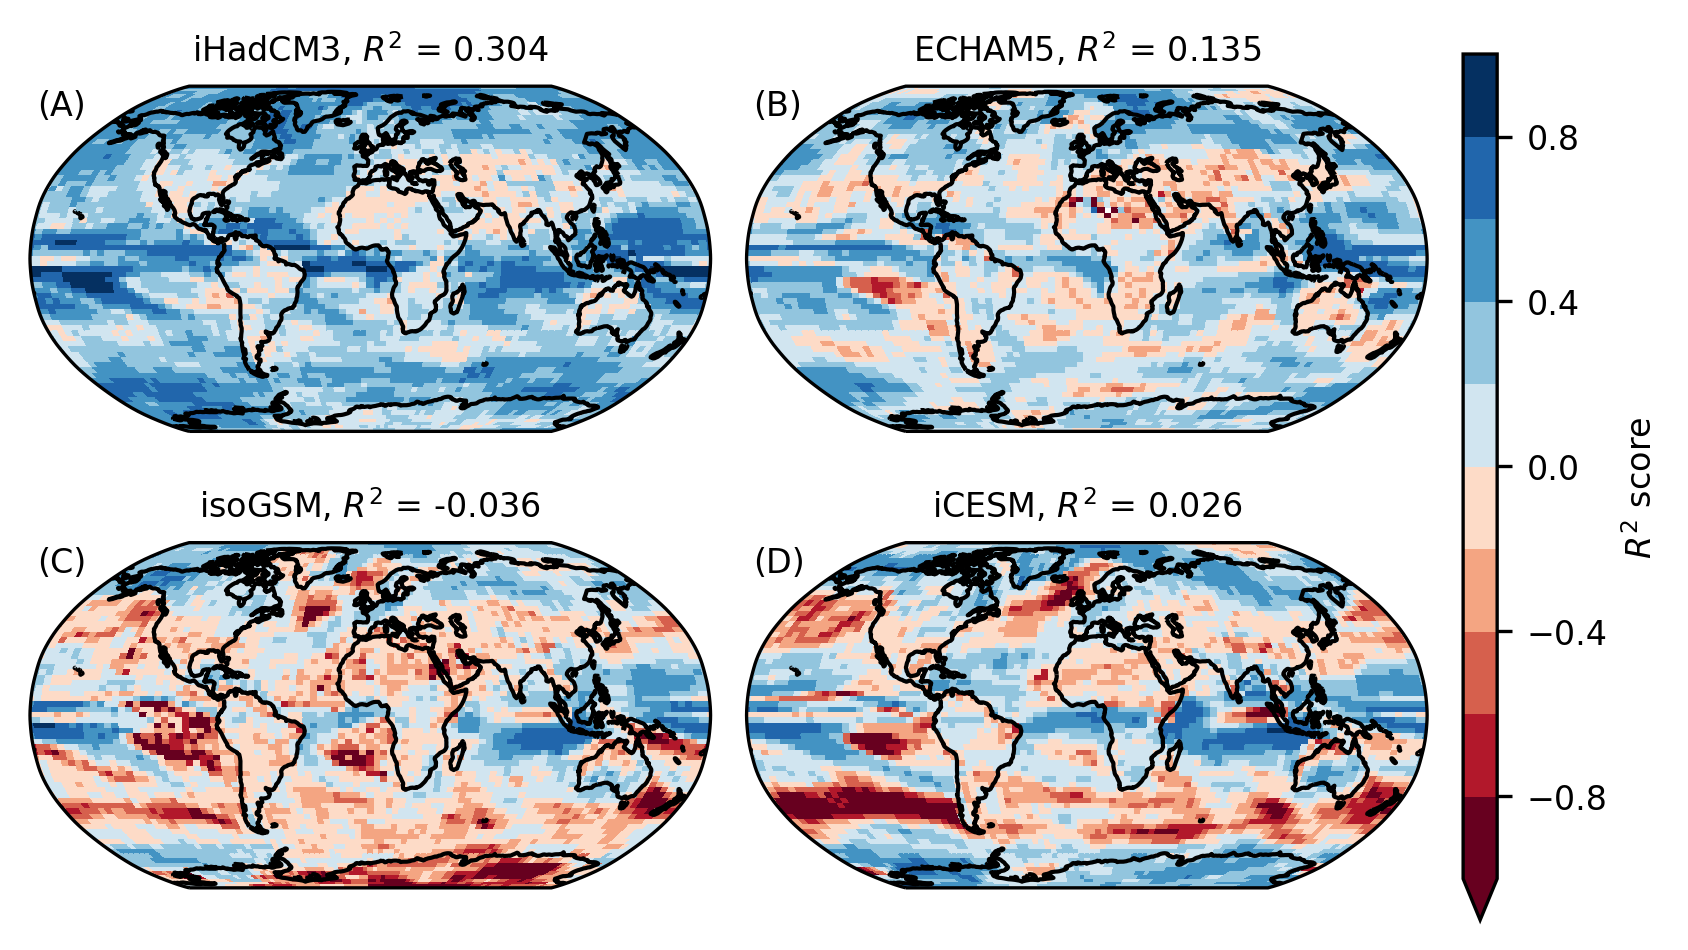

In [44]:
n_rows=2
n_cols=2

figure_width = textwidth
figure_height = 0.8*textwidth * (n_rows) / \
    (n_cols) / r2_style["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.05])

for i, key in enumerate(list(conditions.keys())):
    ax = fig.add_subplot(gs[i//2,i%2], projection=diff_fine_style["PROJECTION"])  
    plot_map(ax, np.mean(np.array(r2s[i]),axis=0), descriptions[0]["DATASET_DESCRIPTION"], r2_style, 
             title=key + r", $R^2$ = {:.3f}".format(np.mean(r2_means[i])), show_colorbar=False)
    add_label_to_axes(ax, "({})".format(alphabet_letters[i]), r2_style)

# fig.suptitle("UNet crossprediction", fontsize=10)


ax_cb=plt.subplot(gs[:,n_cols])
cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=r2_style["CMAP"], norm=r2_style["NORM"]), cax=ax_cb, extend=r2_style["CBAR_EXTEND"])
cbar.set_label(r2_style["CBAR_LABEL"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/crossprediction_pca.pdf")
plt.savefig("Images/crossprediction_pca.png")
plt.savefig("Images/crossprediction_pca.jpg")
plt.savefig("Images/crossprediction_pca.svg")

plt.show()

## Plots for summary figure:

Load required data.

In [45]:
conditions_best = {
    "DATASET_DESCRIPTION": {
                            "PRECIP_WEIGHTING" : False
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "FMAPS": (64,64,128,128),
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  }
}
descriptions_best, predictions_best, gt_best, masks_best = load_data_for_comparison("Output/Reproduce_new/", conditions_best)

10 matching runs found


In [46]:
predictors = get_testset(descriptions_best[0])["predictors"]

In [47]:
from train import load_data

model_training_description = descriptions_best[0]["MODEL_TRAINING_DESCRIPTION"]


# For UNets, we additionally resize the data to fit the divisibility contraint of the network. But this aspect isn't relevant in overview figure, so get a different model style here.
model_training_description["MODEL_TYPE"] = "PCA_Flat"
_, _, testset = load_data(descriptions_best[0]["DATASET_DESCRIPTION"], model_training_description, base_folder="Output/Reproduce_new/", use_prints=False)
model_training_description["MODEL_TYPE"] = "UNet_Flat"

In [48]:
predictors_std = testset[:][0]

predictions = predictions_best[0]

predictions_std, _ = load_compatible_available_runs("Output/Reproduce_new/", descriptions_best[0], keywords_blacklist=[], print_folder_names=False)
predictions_std = predictions_std[0]

1 matching runs found


### Plot data:

Raw temperature:

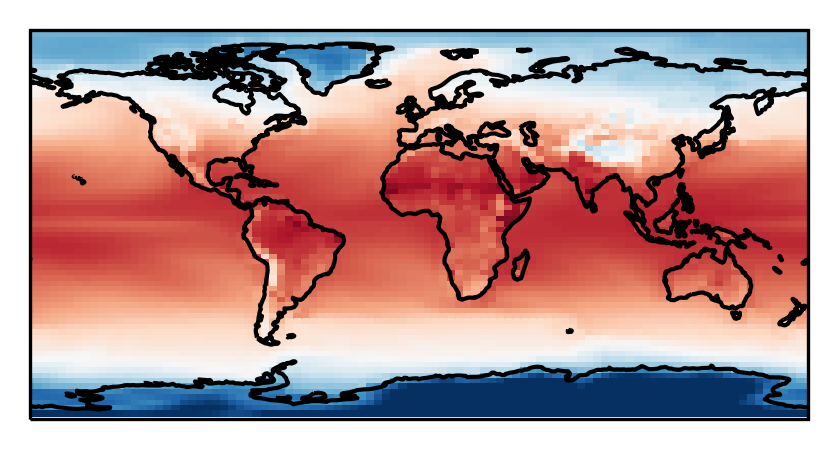

In [49]:
n_rows=1
n_cols=1

figure_width = textwidth / 2
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[figure_width, figure_height], subplot_kw={'projection':  ccrs.PlateCarree()})
plot_map(ax, predictors[0,0,...]-273.15, descriptions_best[0]["DATASET_DESCRIPTION"], tsurf_style, show_colorbar=False)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/tsurf_raw.pdf")
plt.savefig("Images/tsurf_raw.png")
plt.savefig("Images/tsurf_raw.jpg")
plt.savefig("Images/tsurf_raw.svg")

plt.show()

Raw precipitation amount:

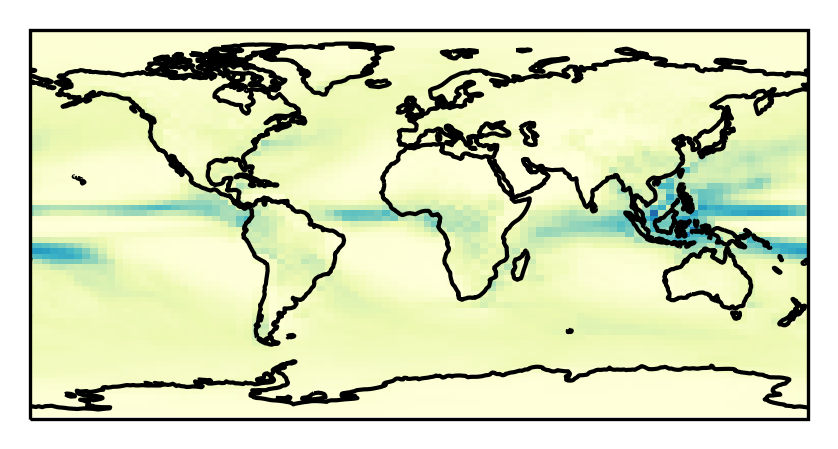

In [50]:
n_rows=1
n_cols=1

figure_width = textwidth / 2
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[figure_width, figure_height], subplot_kw={'projection':  ccrs.PlateCarree()})
plot_map(ax, predictors[0,1,...], descriptions_best[0]["DATASET_DESCRIPTION"], prec_style, show_colorbar=False)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/prec_raw.pdf")
plt.savefig("Images/prec_raw.png")
plt.savefig("Images/prec_raw.jpg")
plt.savefig("Images/prec_raw.svg")

plt.show()

Temperature after standardization:

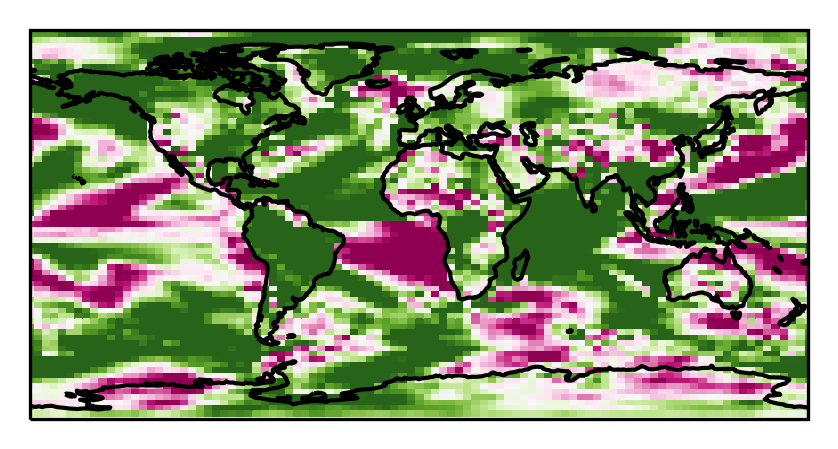

In [51]:
n_rows=1
n_cols=1

figure_width = textwidth / 2
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[figure_width, figure_height], subplot_kw={'projection':  ccrs.PlateCarree()})
plot_map(ax, predictors_std[0,0,...], descriptions_best[0]["DATASET_DESCRIPTION"], std_anom_style, show_colorbar=False)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/tsurf_std.pdf")
plt.savefig("Images/tsurf_std.png")
plt.savefig("Images/tsurf_std.jpg")
plt.savefig("Images/tsurf_std.svg")

plt.show()

Precipitation amount after standardization: 

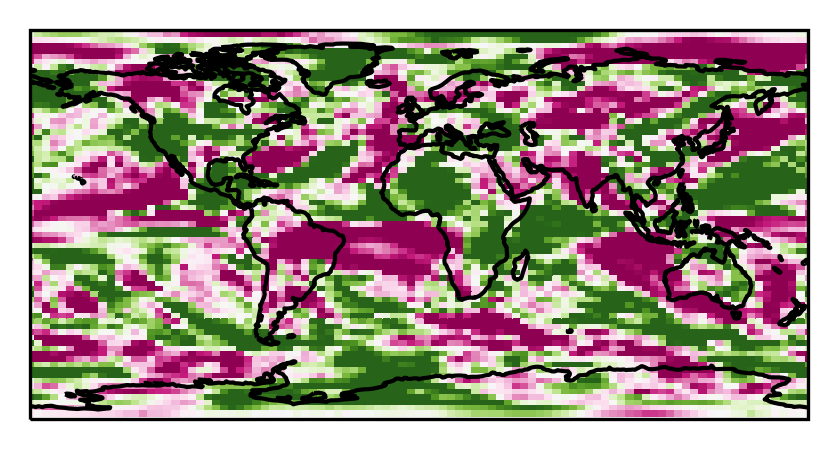

In [52]:
n_rows=1
n_cols=1

figure_width = textwidth / 2
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[figure_width, figure_height], subplot_kw={'projection':  ccrs.PlateCarree()})
plot_map(ax, predictors_std[0,1,...], descriptions_best[0]["DATASET_DESCRIPTION"], std_anom_style, show_colorbar=False)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/prec_std.pdf")
plt.savefig("Images/prec_std.png")
plt.savefig("Images/prec_std.jpg")
plt.savefig("Images/prec_std.svg")

plt.show()

${}^{18}\delta\text{O}$ prediction:

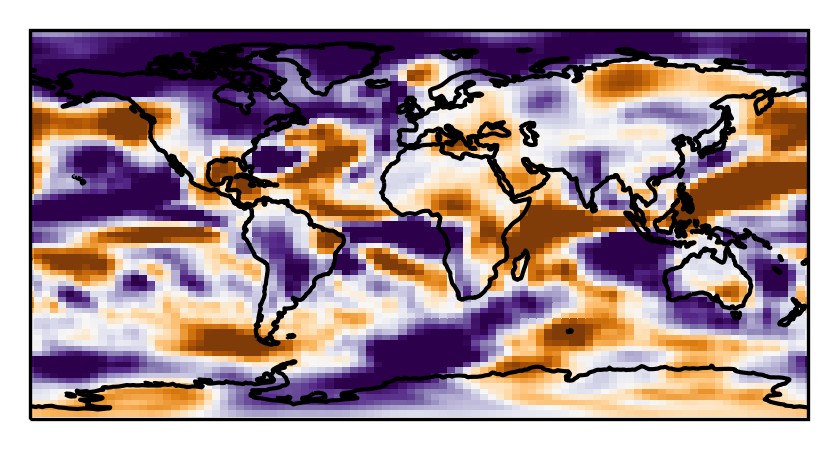

In [53]:
n_rows=1
n_cols=1

figure_width = textwidth / 2
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[figure_width, figure_height], subplot_kw={'projection':  ccrs.PlateCarree()})
plot_map(ax, predictions_std[0,0,...], descriptions_best[0]["DATASET_DESCRIPTION"], std_anom_style_d18O, show_colorbar=False)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/d18_O_std.pdf")
plt.savefig("Images/d18_O_std.png")
plt.savefig("Images/d18_O_std.jpg")
plt.savefig("Images/d18_O_std.svg")

plt.show()

${}^{18}\delta\text{O}$ prediction after rescaling:

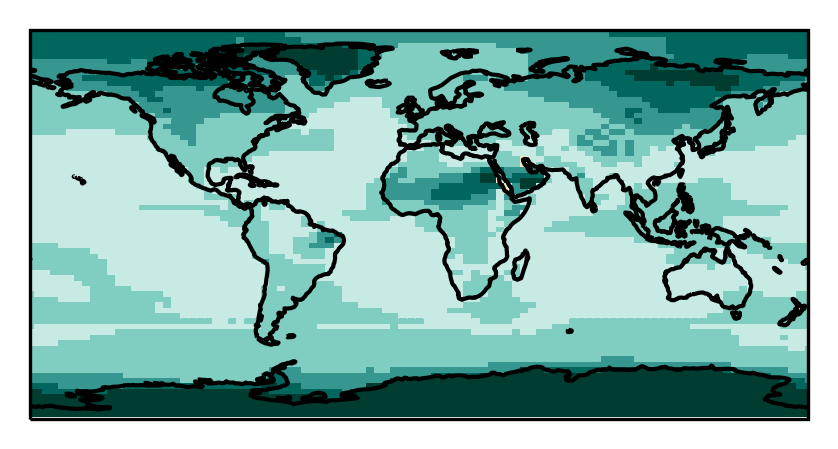

In [54]:
n_rows=1
n_cols=1

figure_width = textwidth / 2
figure_height = textwidth * n_rows / \
    (n_cols) / mean_style["ASPECT_RATIO"]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[figure_width, figure_height], subplot_kw={'projection':  ccrs.PlateCarree()})
plot_map(ax, predictions[0,0,...], descriptions_best[0]["DATASET_DESCRIPTION"], mean_style, show_colorbar=False)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("Images/d18_O.pdf")
plt.savefig("Images/d18_O.png")
plt.savefig("Images/d18_O.jpg")
plt.savefig("Images/d18_O.svg")

plt.show()

## Visualize 3d data:

In [55]:
# import numpy as np

# import gzip
# import netCDF4 as nc
# import pickle

# import matplotlib.pyplot as plt
# import matplotlib


# import cartopy.crs as ccrs
# from cartopy.util import add_cyclic_point


from icosahedron import Icosahedron

In [56]:
ds1 = nc.Dataset("Datasets/iHadCM3/Interpolated/tsurf_yearly_r_5_nbs_6_cons1.nc")
ds2 = nc.Dataset("Datasets/iHadCM3/Interpolated/tsurf_yearly_r_5_nbs_5_cons1.nc")
t = {}
t["6_nb"] = ds1.variables["tsurf"][:].data.squeeze()
t["5_nb"] = ds2.variables["tsurf"][:].data.squeeze()

NameError: name 'nc' is not defined

In [ ]:
ico = Icosahedron(r=5)
regions, vertices = ico.get_voronoi_regions_vertices()
charts = ico.get_charts_cut()
indices_six_nb = []
indices_five_nb = []
for i in range(len(regions)):
    if len(regions[i])>5:
        indices_six_nb.append(i)
    else:
        indices_five_nb.append(i)
# create numpy arrays
indices_six_nb = np.array(indices_six_nb)
indices_five_nb = np.array(indices_five_nb)

In [ ]:
def combine_datasets(dataset_dict, indices_five_nb, indices_six_nb):
    """
    We need to combine the datasets from the seperate files for points with 5 nbs and points with 6 nbs.
    If there only is a file with six-neighbor points, we fill with zeros. 
    """
    assert "6_nb" in dataset_dict.keys()
    combined_data = np.zeros(dataset_dict["6_nb"].shape[:-1] + (dataset_dict["6_nb"].shape[-1]+10,))
    if "5_nb" in dataset_dict.keys():
        combined_data[:,indices_six_nb] = dataset_dict["6_nb"]
        combined_data[:,indices_five_nb] = dataset_dict["5_nb"]
    else:
        combined_data[:,indices_six_nb] = dataset_dict["6_nb"]
        combined_data[:,indices_five_nb] = 0
    return combined_data

In [ ]:
t_c = combine_datasets(t, indices_five_nb, indices_six_nb)-273.16 # convert to celsius

In [ ]:
fig = plt.figure(figsize=prec_style["FIGSIZE"])

ax= fig.add_subplot(1,1,1, projection='3d')

plot_map_3d(ax, t_c[0,:], {"RESOLUTION": 5}, tsurf_style,azim=0, show_colorbar=False)

plt.axis("off")

plt.savefig("Images/temperature_3d.jpg", bbox_inches="tight")
plt.savefig("Images/temperature_3d.png", bbox_inches="tight")
plt.savefig("Images/temperature_3d.pdf", bbox_inches="tight")
plt.savefig("Images/temperature_3d.svg", bbox_inches="tight")
plt.show()